# Amazon find food reviews:

Data consists of 500,000 reviews from amazon fine food starting October 1999 to October 2012

# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from ipywidgets import widgets, interactive
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import copy
from textblob import TextBlob


# Reading the data

In [2]:
df = pd.read_csv("Reviews.csv")

In [3]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Basic statistics on product, users and reviews

In [5]:
print('Number of unique products:', len(df['ProductId'].unique()))

Number of unique products: 74258


In [6]:
print('Number of unique users:', len(df['UserId'].unique()))

Number of unique users: 256059


In [7]:
print('Estimate of number unique reviews:', len(df['Text'].unique()))

Estimate of number unique reviews: 393579


In [8]:
print('Initial size')
df.shape

Initial size


(568454, 10)

# Data pre-processing

# Converting the Unix time to actual time

In [9]:
df['Date'] = pd.to_datetime(df['Time'], unit='s')

In [10]:
# calculate Count of reviews for each product
df_counts = df[['ProductId', 'Id']]
df_counts = df_counts.groupby(['ProductId']).count().reset_index().rename(columns = {'Id':'Counts'})

# calculate Min and Max review date for each product
df_minmax = df.groupby(['ProductId']).agg({'Date':[np.min,np.max]}).reset_index().rename(columns = {'amin':'Min', 'amax':'Max'})
df_minmax.columns = ["".join(x) for x in df_minmax.columns.ravel()]

# merge two dataframes
df_agg = pd.merge(df_counts, df_minmax, on=["ProductId"])
df_agg.head()

,ProductId,Counts,DateMin,DateMax
0,0006641040,37,1999-10-08,2012-09-23
1,141278509X,1,2012-03-24,2012-03-24
2,2734888454,2,2007-10-11,2007-11-25
3,2841233731,1,2012-08-25,2012-08-25
4,7310172001,173,2005-01-04,2012-10-26


In [11]:
# calculate the difference in years and sort in descending order by years and then counts
df_agg['Diff_Years'] = df_agg['DateMax'] - df_agg['DateMin']
df_agg['Diff_Years'] = (df_agg['Diff_Years']/np.timedelta64(1, 'Y')).astype(int)
df_sorted = df_agg.sort_values(['Diff_Years', 'Counts'], ascending = (False,False))
df_sorted.head()

,ProductId,Counts,DateMin,DateMax,Diff_Years
12,B00004CXX9,195,1999-12-02,2012-10-22,12
11,B00004CI84,189,1999-12-06,2012-10-22,12
20,B00004RYGX,189,1999-12-06,2012-10-22,12
22,B00004S1C6,61,2000-08-09,2012-10-19,12
8,B00002N8SM,38,2000-01-24,2012-09-28,12


In [12]:
# Filter the rows by year 2006 and Diff_Years = 6. Also, select only top 15 product id's.
df_sorted = df_sorted[(df_sorted['Diff_Years'] == 6) & (df_sorted['DateMin'] > '2005-12-31') & (df_sorted['DateMax'] < '2013-01-01')]
df_sorted = df_sorted[['ProductId']].head(15)
df_sorted

,ProductId
7387,B000CNB4LE
46406,B003CIBPN8
60392,B004SRFYMK
60393,B004SRH2B6
5473,B0007A0AQM
5474,B0007A0AQW
7062,B000BRR8VQ
11712,B000H0ZJHW
11713,B000H0ZJIG
11728,B000H1217M


In [13]:
# the final dataframe with all columns of the selected 15 products
df_final = pd.merge(df, df_sorted, on = ['ProductId'])
len(df_final)

5986

In [14]:
df_final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date
0,29992,B000DZFMEQ,A3P70L7MF8L3L3,J. E. Pote,1,1,5,1268179200,Pamela's Bread Mix,At last a really delicious bread mix that tast...,2010-03-10
1,29993,B000DZFMEQ,A1ASH1LE6HZ3Y3,Linda M. Walker,1,1,2,1256947200,Dated,I purchased a case of this bread mix because m...,2009-10-31


# Cleaning the text of reviews (multiple steps)

* Removing partially scraped containing html headers
* Remove special characters e.g. "{$1?&") from the text
* Removing extra space, parsing the data
* Removing NaN (very few)

# Removing partially scraped html from data

In [15]:
#function to remove hmtl tags and special char from text review.

special_char_list=['</span','<br/>','<br>','br','href','</a>''\\','`','\"',"'",'*','_','{','}','[',']','(',')',';','@','^','&','>','#','+',':','-','_','=','|','>','<','~','.','!','$','/',',','?','%','0','1','2','3','4','5','6','7','8','9']

def clean_text(col):      
    for word in special_char_list:
        if word in col: 
            col=col.replace(word,"").replace("  "," ")
    return col

In [16]:
# applying special character removal to dataframe
df_final['Text']=df_final['Text'].apply(clean_text)

In [17]:
df_final.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
Date                      0
dtype: int64

# Exploratory data analysis

# Trend  in Review count over years

In [18]:
#creating "Year" attribute in data frame
df_final['Year'] = df_final.Date.dt.year

df_review = df_final[['Year','Text']]
df_review = df_review.groupby(['Year']).count().reset_index().rename(columns = {'Text':'Counts'})

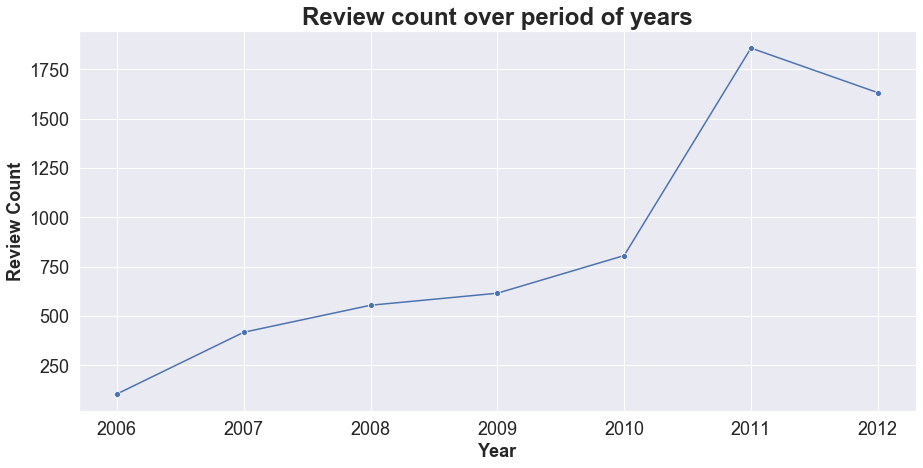

In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

title = 'Review count over period of years'
f,ax = plt.subplots(1, figsize=(15,7))
ax = sns.lineplot(x="Year", y="Counts", marker='o',data=df_review, ci=90)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel('Year', fontsize=18, weight = 'bold')
ax.set_ylabel('Review Count', fontsize=18, weight = 'bold')
plt.title(title, fontsize=24, y=1, weight = 'bold')
plt.show()

# Distribution of count of reviews across products

In [20]:
df_review_products = df_final.groupby(['ProductId']).count()['Id'].reset_index().sort_values(by='Id',ascending=False)
# df_review_products.head()

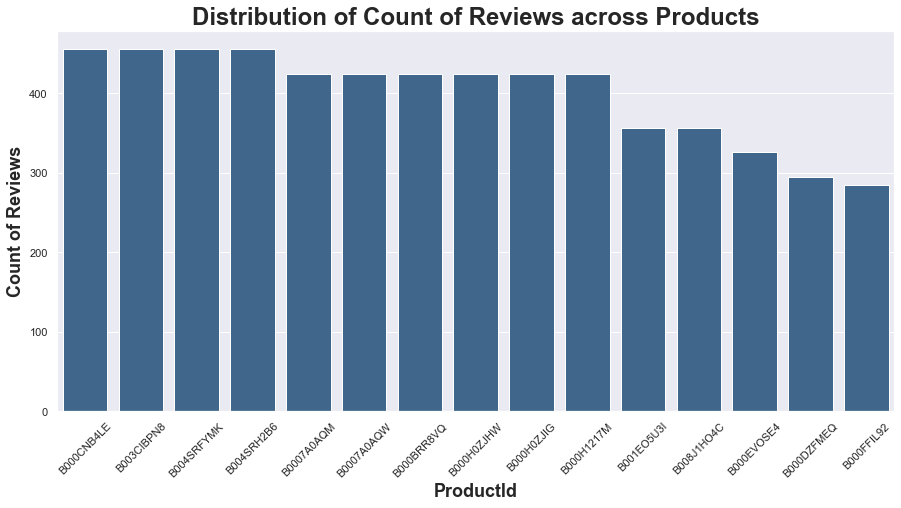

In [21]:
plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Id", data=df_review_products, color=(0.2, 0.4, 0.6, 0.6))
#plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.title('Distribution of Count of Reviews across Products',fontsize=24, y=1, weight = 'bold')
plt.ylabel('Count of Reviews',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

# Distribution of Avg. score of Reviews across Products

In [22]:
df_avg_review_products = df_final.groupby(['ProductId']).mean()['Score'].reset_index().sort_values(by='Score',ascending=False)
# df_avg_review_products.head()

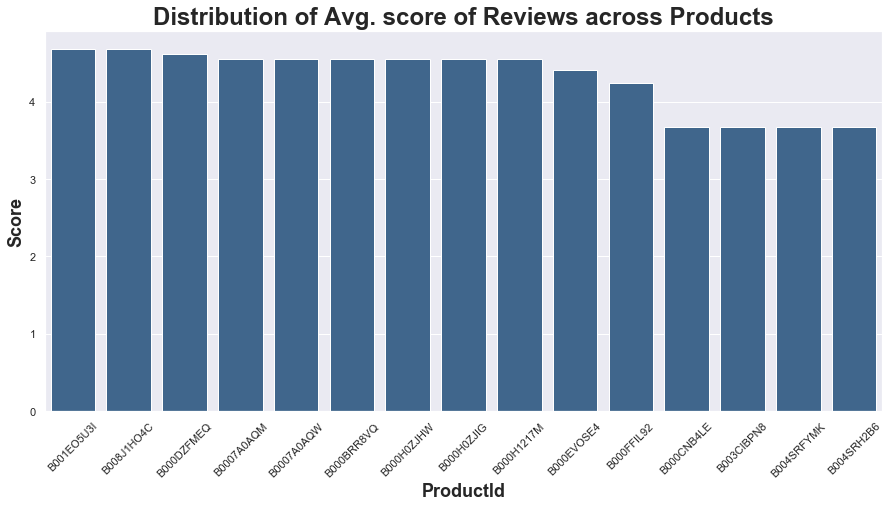

In [23]:
plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Score", data=df_avg_review_products, color=(0.2, 0.4, 0.6, 0.6))
#plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.title('Distribution of Avg. score of Reviews across Products',fontsize=24, y=1, weight = 'bold')
plt.ylabel('Score',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

# Total Number of Reviews of Products over the period of Time

In [24]:
#creating pivoted data for heatmap chart
reviews_product_years = pd.crosstab(df_final['ProductId'],df_final['Year'])
reviews_product_years.head()

Year,2006,2007,2008,2009,2010,2011,2012
ProductId,,,,,,,
B0007A0AQM,1,9,25,48,35,139,167
B0007A0AQW,1,9,25,48,35,139,167
B000BRR8VQ,1,9,25,48,35,139,167
B000CNB4LE,6,9,10,11,100,198,122
B000DZFMEQ,9,44,59,72,56,38,17


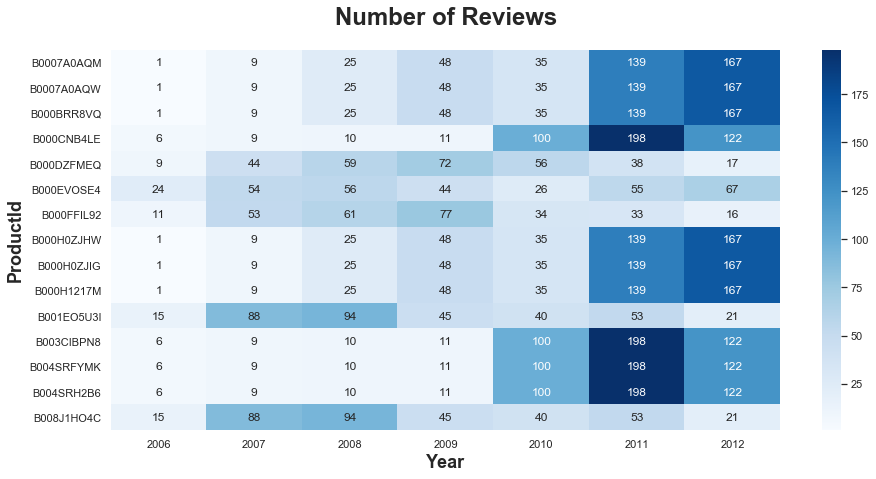

In [25]:
#creating heatmap plot
fig, ax = plt.subplots(figsize = (15,7))
plt.title("Number of Reviews",fontsize=24, y=1, weight = 'bold')
plt.ylabel('ProductId',fontsize=18, weight = 'bold')
plt.xlabel('Year',fontsize=18, weight = 'bold')
ttl = ax.title
ttl.set_position([0.5,1.05])

sns.heatmap(reviews_product_years,annot=True,cmap='Blues', fmt='g');

# Average Score of Products over the period of Time

In [26]:
#creating pivoted data for heatmap chart
score_product_years = pd.pivot_table(df_final, values='Score', index=['ProductId'],columns=['Year'], aggfunc=np.mean)
score_product_years

Year,2006,2007,2008,2009,2010,2011,2012
ProductId,,,,,,,
B0007A0AQM,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934
B0007A0AQW,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934
B000BRR8VQ,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934
B000CNB4LE,4.166667,4.888889,4.200000,4.818182,2.790000,3.762626,3.983607
B000DZFMEQ,5.000000,4.636364,4.728814,4.625000,4.375000,4.631579,4.588235
B000EVOSE4,4.750000,4.388889,4.303571,4.340909,4.576923,4.272727,4.507463
B000FFIL92,4.454545,4.245283,4.213115,4.350649,3.647059,4.545455,4.312500
B000H0ZJHW,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934
B000H0ZJIG,5.000000,5.000000,4.920000,4.645833,4.342857,4.474820,4.532934


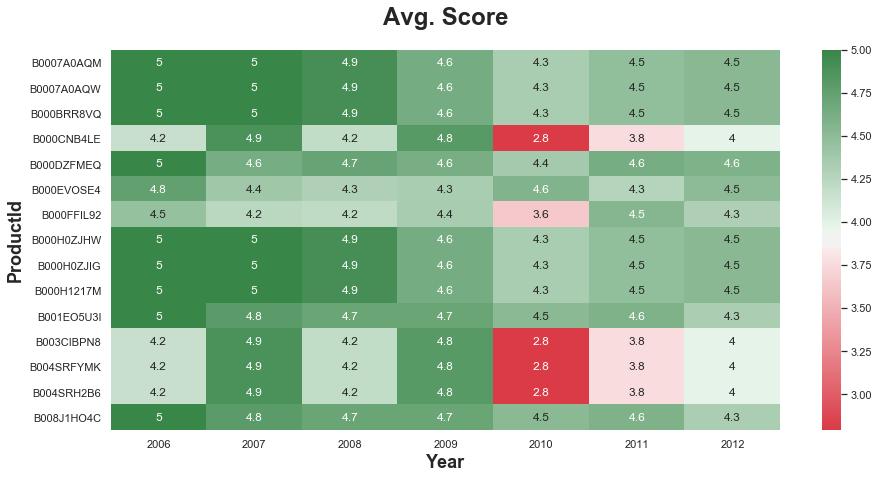

In [27]:
#creating heatmap plot
fig, ax = plt.subplots(figsize = (15,7))
plt.title("Avg. Score",fontsize=24, y=1, weight = 'bold')
plt.ylabel('ProductId',fontsize=18, weight = 'bold')
plt.xlabel('Year',fontsize=18, weight = 'bold')
ttl = ax.title
ttl.set_position([0.5,1.05])

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(score_product_years,annot=True,cmap=cmap, fmt='.2g');

In [28]:
#removing products with similar trend
ProdcutIds = ['B0007A0AQW','B000BRR8VQ','B000H0ZJIG','B000H1217M','B004SRH2B6']
df_final = df_final[df_final.ProductId.isin(ProdcutIds)==False]

# Sentiment Analysis

# Changing Score Attribute to Sentiment Text

In [29]:
df_final.loc[df_final.Score>3,'Score_Sentiment'] = 'Positive'
df_final.loc[df_final.Score==3,'Score_Sentiment'] = 'Neutral'
df_final.loc[df_final.Score<3,'Score_Sentiment'] = 'Negative'
df_final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Year,Score_Sentiment
0,29992,B000DZFMEQ,A3P70L7MF8L3L3,J. E. Pote,1,1,5,1268179200,Pamela's Bread Mix,At last a really delicious ead mix that tastes...,2010-03-10,2010,Positive
1,29993,B000DZFMEQ,A1ASH1LE6HZ3Y3,Linda M. Walker,1,1,2,1256947200,Dated,I purchased a case of this ead mix because my ...,2009-10-31,2009,Negative
2,29994,B000DZFMEQ,A32PVZEV0QTHMK,Manisha,1,1,3,1256515200,TOO SWEET,I thought this product would be more like eadb...,2009-10-26,2009,Neutral
3,29995,B000DZFMEQ,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,3,1254268800,Not the best,I really like Pamelas baking mix so I tried th...,2009-09-30,2009,Neutral
4,29996,B000DZFMEQ,AU714FVNMGW4E,"Anita L. Burnham ""Anita B""",1,1,5,1253750400,Gluten Free Goodness,This is the best gf ead mix I have found by fa...,2009-09-24,2009,Positive


# Product & Reviews (Positive, Neutral and Negative) Distribution

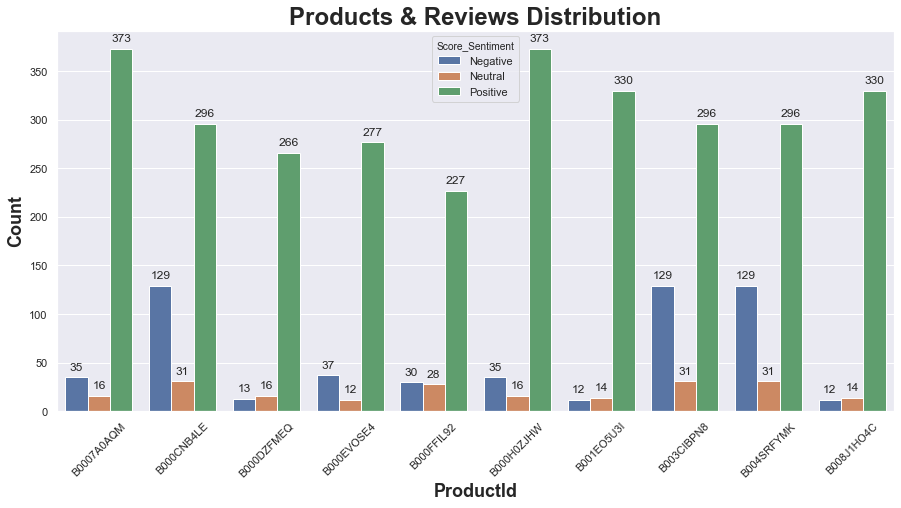

In [30]:
product_review_groupby = df_final.groupby(['ProductId','Score_Sentiment']).count()['Id'].reset_index()

plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Id", hue="Score_Sentiment", data=product_review_groupby)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks(rotation=45)
plt.title('Products & Reviews Distribution',fontsize=24, y=1, weight = 'bold')
for p in bar_plot.patches:
    bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Count',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

In [31]:
product_review_year_groupby = df_final.groupby(['ProductId','Score_Sentiment','Year']).count()['Id'].reset_index()
product_pos_review_groupby = product_review_year_groupby[product_review_year_groupby['Score_Sentiment']=='Positive']
product_neg_review_groupby = product_review_year_groupby[product_review_year_groupby['Score_Sentiment']=='Negative']
product_neu_review_groupby = product_review_year_groupby[product_review_year_groupby['Score_Sentiment']=='Neutral']

# Product & Reviews (Positive) Distribution across Years

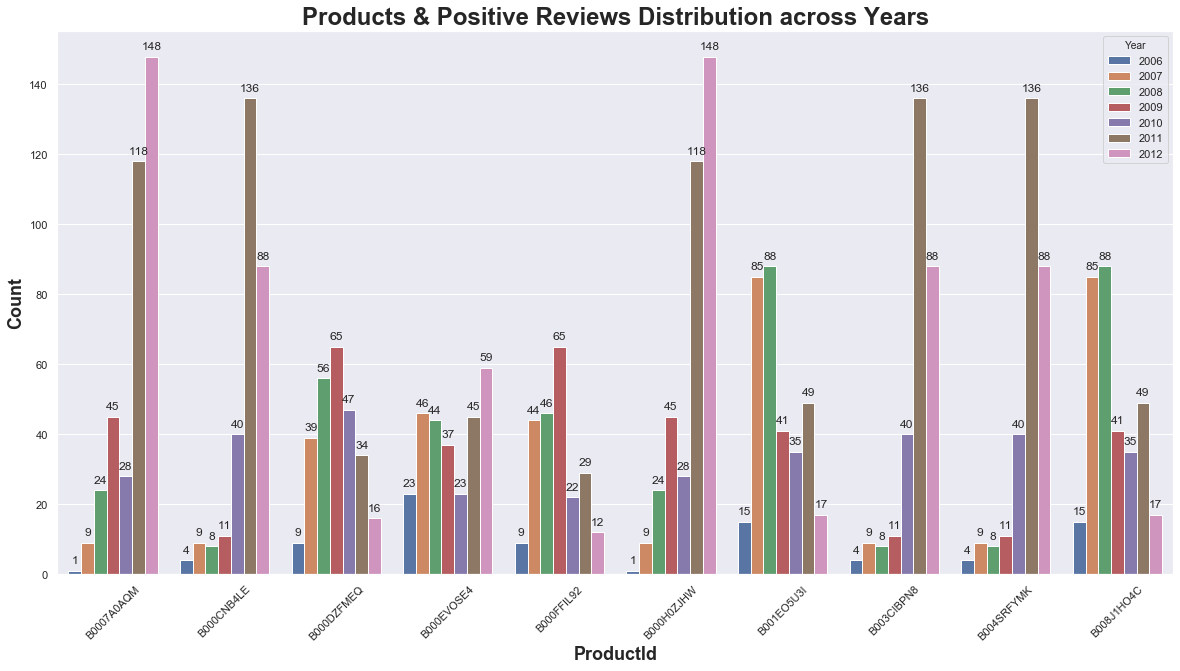

In [32]:
plt.figure(figsize=(20, 10))
bar_plot = sns.barplot(x="ProductId", y="Id", hue="Year", data=product_pos_review_groupby)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks(rotation=45)
plt.title('Products & Positive Reviews Distribution across Years',fontsize=24, y=1, weight = 'bold')
for p in bar_plot.patches:
    bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Count',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

In [33]:
productid_dropdown = widgets.Dropdown(
    options = ['All'] + list(product_review_year_groupby['ProductId'].unique()),
    value = 'All',
    description = 'Product ID'
)

In [34]:
product_review_year_groupby.head()
product_review_year_groupby.groupby(['Score_Sentiment','Year']).sum()['Id'].reset_index()

,Score_Sentiment,Year,Id
0,Negative,2006,2
1,Negative,2007,15
2,Negative,2008,24
3,Negative,2009,23
4,Negative,2010,177
5,Negative,2011,206
6,Negative,2012,114
7,Neutral,2006,7
8,Neutral,2007,13
9,Neutral,2008,26


In [35]:
def line_chart_per_product(productid_dropdown):
    
    if productid_dropdown == 'All':
        review_year_groupby_prod = product_review_year_groupby.groupby(['Score_Sentiment','Year']).sum()['Id'].reset_index()
    else:
        review_year_groupby_prod = product_review_year_groupby[product_review_year_groupby['ProductId']==productid_dropdown]
    
    plt.figure(figsize=(15, 7))
    line_plot = sns.lineplot(x="Year", y="Id", hue="Score_Sentiment", data=review_year_groupby_prod)
    plt.ticklabel_format(style='plain', axis='y',useOffset=False)
    plt.xticks(rotation=45)
    plt.title('Distribution of Reviews across Years',fontsize=22, y=1, weight = 'bold')
    for p in bar_plot.patches:
        bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.ylabel('Count',fontsize=18, weight = 'bold')
    plt.xlabel('Year',fontsize=18, weight = 'bold')
    plt.show();
    #data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtcAAAHICAYAAACF5saOAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3Xd8leXh/vHPnZ2QBJKAsqeMAAnIUIYCVqaKyhJwICLjq6211lrcUquWtv6ktbYYZIoVAQFBQUUELCAyDTMsAQkgAgkjgYSs+/fHeYgBAgTIyZNxvV+vvDznmdc5OcjFfe7zHGOtRURERERErp2P2wFEREREREoLlWsRERERkUKici0iIiIiUkhUrkVEREREConKtYiIiIhIIVG5FhEREREpJCrXIuJ1xph3jTEvFdKxahpjUo0xvs79pcaYoYVxbOd4nxtjHi6s413BeV8zxhw1xhwq4vM+b4wZX5TnFBEpzYyucy0i18IYsxe4HsgCsoGtwPvAOGttzlUca6i1dtEV7LMU+MBae8UF0RgzCrjBWvvgle5bmIwxNYAdQC1r7eF81ncCFgOnAQscBEZbaycVZc6yyhjzOtDGWnt7nmUNgLVAe2vtJtfCiUixo5FrESkMPa21YUAtYDQwEphQ2CcxxvgV9jGLiVpAUn7FOo+D1tpQIBx4CnjPGNOwSNIVc2ffxfCiV4HKxphhzvkM8B7wVmEX61L8GhcpM1SuRaTQWGtPWGvnAf2Bh40xTQGMMZONMa85tysaYz4zxhw3xiQbY5YZY3yMMVOBmsCnzrSPPxpjahtjrDHmUWPMPmBxnmV5S0g9Y8xqY8wJY8xcY0ykc65Oxpj9eTMaY/YaYzobY7oDzwP9nfNtcNbnTjNxcr1ojPnRGHPYGPO+Maa8s+5sjoeNMfucKR0vXOy5McaUd/Y/4hzvRef4nYGvgKpOjsmXeY6ttXYBkAzE5jl+I2PMV85zut0Yc5+zvI0x5lDeAmqM6WWM2ejcHmWM+SDPujbGmG+d388GZ9QcY8xtxphNebZbZIxZnef+cmPMvc7tkcaYA8aYFCdL7ojvec/JncaY740xJ40xic47CXnX35InS6IxZrCzfLIxZqwxZoEx5hRw28WeX2f7G4wx3zivj6PGmOnOcmOMGeP8bk8YYzaefc2e95yfAYYAo40x1YDhQATwep6sQ40x24wxx4xnalGNPOveMcbsdx7nGmNMuzzrXjPGTDfGTDPGpAAPOr+D9c72Pxtj/p7f8ycixZS1Vj/60Y9+rvoH2At0zmf5PuAx5/Zk4DXn9l+AdwF/5+dWfpmids6xgNp4pkG8D5QDgvMs83O2WQocAJo628zCM00EoBOw/2J5gVFnt82zfimeqSngKVS7gLpAKDAbmHpetvecXM2AM0D0RZ6n94G5QJiz7w7g0YvlPG/f3PV4BkXuBnKAG51l5YBE4BHAD2gBHAWaOOt/ALrkOd5M4NnznwOgGpAE3OGcp4tzvxIQBKQBFZ1zHMIzPSXMefxpQBTQ0MlSNc/zVO8SjyvGOVcs8DNwr7OuJpACDMTzOokCmud5PZ0A2jv7Bl3m+Z0GvJBn21uc5d2AdUAFwADRQJVL/B7+H/C189y2yrO8L7Ddeex+znO6LM/6h4BIZ91IPK/XQGfda0AG0NPJFwysAQY668OAm93+c64f/ein4D8auRYRbzmIp1CcLxOogmd+caa1dpm19nIf/hhlrT1lrU27yPqp1trN1tpTwEvAfaZwpgo8gOet/93W2lTgOWDAeaPmf7LWpllrNwAb8JTsczhZ+gPPWWtTrLV78RS1h64gS1VjzHE8JXYO8Htr7ffOuruAvdbaSdbaLGvtejz/yOjrrJ+Gp6RijAnDU56n5XOOB4EF1toF1toca+1XeOYV32GtTXdudwBaARuB5XgKbhtgp7U2Cc+8+0CgsTHG31q711r7Q34PyFq71Fq7yTnXRidTR2f1A8Aia+0053WSZK2Nz7P7XGvtCuuZ15/JpZ/fTDxTb6paa9OttcvzLA8DGuH5B16Ctfan/J9+AF4EbsDzelubZ/kI4A1r7XZrbRaewnyTM8qNtXaqtTbZWfc3PFN7bsiz/3Jr7afO85Dm5KpvjIlyHs+qS2QSkWJG5VpEvKUanqkL5/s7ntHghcaY3caYZwtwrMQrWP8jnpHOigVKeWlVnePlPbYfng9wnpX36h6n8Yxwn68iEJDPsapdQZaD1toKeIrZ28Cv8qyrBdzsTJ847pTwB4DKzvoPgd7GmECgN7DeWps3S97j9DvvOLfg+ccQwDd4Rps7OLeX4inDHZ37WGt3Ab/DM3p72BjzkTGman4PyBhzszFmiTOV4wTwf/zye6uBZ8T9YvL+zi/3/P4Rz8j0amPMFmPMECfrYuAd4N/Az8aYccaY8Iud0Cm+e4At562qBfw7z3N2FM87C9Wdx/lHZ8rICeAYnnca8r4+z399PwI0BrYbz3SnOy7xPIhIMaNyLSKFzhjTGk+xWX7+Omck7mlrbV08b4X/Ps+c3IuNYF9uZLtGnts18Yz8HQVOASF5cvnimeJQ0OMexFOc8h47C8/0hStxlF9GT/Me68AVHgfrmf87Eog5O8cZTzn7xlpbIc9PqLX2MWefrXjKZg/gfjxlOz+JeEZl8x6nnLV2tLP+/HL9DeeVa+d8H1prb3EerwX+epHzfQjMA2pYa8vjmS5k8mSpd6mnIs/tSz6/1tpD1tph1tqqeEaZ/2OMucFZ97a1tiXQBGgAPHOJc15MIp4pKHmft2Br7SpjzG3A74E+eKafRACpeR7n+Y8FZwR8AHAdnhH4WcaYoKvIJSIuULkWkUJjjAk3xtwFfIRnHu8FV1IwxtzlfMDMACfxTCPIdlb/jGd+85V60BjT2BgTgufKDh9ba7PxzLsNcj4454/nbf3APPv9DNQ++8G3fEwDnjLG1DHGhAJvANOdt/cLzMkyA3jdGBNmjKmFp3B9cOk9L3q8DDyl62Vn0WdAA2PMQ8YYf+entTEmOs9uHwK/xVOMZ17k0B8APY0x3YwxvsaYIOP5UGh1Z/23eOYV3wSsttZuwRk1B/4HYIxpaIz5lTNKno5nGkv2BWfyCAOSrbXpxpib8BT/s/4LdDbG3GeM8TPGRBljml/k+bjk82uM6ZfnMRzDU2aznefoZue1ccrJe7Gsl/Iu8MLZ59sYU8EYc3ZKThief5AdxfOOyig8I9cX5fweKzpTXk44ea/ospYi4h6VaxEpDJ86VzpIxPPBsbfwvLWdn/rAIjyjdyuB/1hrlzrr/gK86Ly9/ocrOP9UPB9yO4TnA2u/Bc/VS4DHgfF4RjFPAXmvHnK2ZCYZY9bnc9yJzrH/h2c6QDrwxBXkyusJ5/y78Yzof+gc/2pNBGoaY3paa1OArsAAPKPth/CMFuf9h8Q0PKPOi621R/M7oLU2EbgHz1VUjuD5fT6D83eFM6d9PbDFKfjg+R3+aH+5jGAgnssxHnVyXOccLz+PA686r52X8RTks1n24Zkb/jSe6UXx5DOfPY9LPb+tgVXGmFQ8I+VPWmv34Jli8x6ewv0jng9vvnmJc+TLWjsTz2t+pjHmJJ756N2c1QvwvN534vkw7UngUvO6wfO4E5zn5U2gf57nW0SKOX2JjIiIiIhIIdHItYiIiIhIIVG5FhEREREpJCrXIiIiIiKFROVaRERERKSQ+F1+k+KrYsWKtnbt2m7HEBEREZFSbt26dUettZUut12JLte1a9dm7dq1l99QREREROQaGGPy+2bbC2haiIiIiIhIIVG5FhEREREpJCrXIiIiIiKFpETPuc5PZmYm+/fvJz093e0o4gVBQUFUr14df39/t6OIiIiIXKDUlev9+/cTFhZG7dq1Mca4HUcKkbWWpKQk9u/fT506ddyOIyIiInKBUjctJD09naioKBXrUsgYQ1RUlN6VEBERkWKr1JVrQMW6FNPvVkRERIqzUlmuRURERETcoHItIiIiIlJIVK695PXXX6dJkybExsbSvHlzVq1aVSLPHx8fz4IFC3Lvz5s3j9GjRxdWzHwtXbqUb7/91qvnEBEREfGGUne1kOJg5cqVfPbZZ6xfv57AwECOHj1KRkbGVR8vKysLP7+C/6oK8/zx8fGsXbuWO+64A4C7776bu++++6qOVVBLly4lNDSUdu3aefU8IiIiIoVNI9de8NNPP1GxYkUCAwMBqFixIlWrVmXNmjW0a9eOZs2acdNNN5GSkkJ6ejqPPPIIMTEx3HjjjSxZsgSAyZMn069fP3r27EnXrl0B+Pvf/07r1q2JjY3llVdeueLzA6xbt46OHTvSsmVLunXrxk8//QRAp06dGDlyJDfddBMNGjRg2bJlZGRk8PLLLzN9+nSaN2/O9OnTmTx5Mr/5zW8AGDx4MI899hi33XYbdevW5ZtvvmHIkCFER0czePDg3DwLFy6kbdu2tGjRgn79+pGamgpA7dq1eeWVV2jRogUxMTFs27aNvXv38u677zJmzBiaN2/OsmXLCvE3IyIiIuJdKtde0LVrVxITE2nQoAGPP/4433zzDRkZGfTv359//vOfbNiwgUWLFhEcHMy///1vADZt2sS0adN4+OGHcy81t3LlSqZMmcLixYtZuHAhO3fuZPXq1cTHx7Nu3Tr+97//Ffj84PmCnSeeeIKPP/6YdevWMWTIEF544YXc/bKysli9ejX/+Mc/+NOf/kRAQACvvvoq/fv3Jz4+nv79+19wrmPHjrF48WLGjBlDz549eeqpp9iyZQubNm0iPj6eo0eP8tprr7Fo0SLWr19Pq1ateOutt3L3r1ixIuvXr+exxx7jzTffpHbt2vzf//0fTz31FPHx8dx6662F9nsRERER8TZNC/GC0NBQ1q1bx7Jly1iyZAn9+/fnhRdeoEqVKrRu3RqA8PBwAJYvX84TTzwBQKNGjahVqxY7duwAoEuXLkRGRgKe0d+FCxdy4403ApCamsrOnTvp0KFDgc4/evRoWrVqxebNm+nSpQsA2dnZVKlSJXe/3r17A9CyZUv27t1boMfas2dPjDHExMRw/fXXExMTA0CTJk3Yu3cv+/fvZ+vWrbRv3x6AjIwM2rZtm+85Z8+eXaBzioiIiBRXKtde4uvrS6dOnejUqRMxMTH8+9//zvcazdbaix6jXLly52z33HPPMWLEiKs6/5QpU2jZsiVNmjRh5cqV+e5zdhqJr68vWVlZBTrP2X18fHxyb5+9n5WVha+vL126dGHatGmFdk4RERFvO3HmBCH+Ifj7+LsdRUoYTQvxgu3bt7Nz587c+/Hx8URHR3Pw4EHWrFkDQEpKCllZWXTo0IH//ve/AOzYsYN9+/bRsGHDC47ZrVs3Jk6cmDtf+cCBAxw+fLjA569VqxYNGzbkyJEjueU6MzOTLVu2XPKxhIWFkZKScgWP/lxt2rRhxYoV7Nq1C4DTp0/njsx765wiIiLX4nj6ce6YfQf95vVjS9Kl/54UOZ/KtRekpqby8MMP07hxY2JjY9m6dSuvvvoq06dP54knnqBZs2Z06dKF9PR0Hn/8cbKzs4mJiaF///5Mnjz5nBHgs7p27cr9999P27ZtiYmJoW/fvhctoPmdf9SoUQQEBPDxxx8zcuRImjVrRvPmzS97ybvbbruNrVu35n6g8UpVqlSJyZMnM3DgQGJjY2nTpg3btm275D49e/Zkzpw5+kCjiIi44oOEDziZcZITGSd4YP4D/Cf+P2TmZLodS0oIc6lpCcVdq1at7Nq1a89ZlpCQQHR0tEuJpCjodywiIt6SkpFCt4+7cXOVmxnVbhSjV4/ms92fER0Zzeu3vE79iPpuRxSXGGPWWWtbXW47jVyLiIiIOKZtm0ZKZgrDY4dTPrA8f7n1L4zpNIafT/9M/8/6M3HzRLJzst2OKcWYPtBYgiUlJXH77bdfsPzrr78mKirKhUQiIiIl1+nM00zdOpUO1TsQHfXLO6Sda3Xmxutu5M/f/Zkx68aweN9iXr/ldWqF13IxrRRXKtclWFRUFPHx8W7HEBERKRVm7pjJ8TPHGR47/IJ1UcFRjOk0hvl75vPGqjfoO68vv2v5OwY2GoiP0UQA+YVeDSIiIlLmpWelM2nzJNpUaUOzSs3y3cYYw11172LO3XNoWbklo1ePZtjCYRxMPVjEaaU4U7kWERGRMm/2ztkkpSflO2p9vuvLXc/Y28fySttX2Hx0M73n9Wb2ztmX/O4KKTtUrkVERKRMy8jOYOLmibS4rgWtrr/sxSAAzyh23wZ9mXX3LKIjo3nl21f49de/5vDp/L+DQsoOlWsvMMbw9NNP595/8803GTVqVKGf54033jjnfrt27Qr9HCIiIqXdvB/m8fPpnxkROyLfb1O+lOph1ZnQbQIjW49k9aHV9JrbiwW7F2gUuwxTufaCwMBAZs+ezdGjR716nvPL9eW+EEZERETOlZWTxfhN42ka1ZS2Vdte1TF8jA8PNn6QmT1nUju8NiOXjeTpb54mOT25kNNKSaBy7QV+fn4MHz6cMWPGXLDuyJEj9OnTh9atW9O6dWtWrFiRu7xLly60aNGCESNGUKtWrdxyfu+999KyZUuaNGnCuHHjAHj22WdJS0ujefPmPPDAAwCEhoYC0L9/fxYsWJB7zsGDBzNr1iyys7N55plnaN26NbGxscTFxXn1eRARESnuFuxZwIHUAwyPHX7Fo9bnq1O+DlN6TOHJFk+yJHEJveb2YvG+xYWUVEqKUv0NjX/6dAtbD54s1HM2rhrOKz2bXHKb0NBQDh48SGxsLBs2bOC9994jNTWVUaNGcf/99/P4449zyy23sG/fPrp160ZCQgK/+c1vqFatGs899xxffPEFPXr04MiRI1SsWJHk5GQiIyNJS0ujdevWfPPNN0RFRREaGkpqauo5501NTWXOnDl88sknTJkyhYyMDOrVq8eOHTuYOnUqhw8f5sUXX+TMmTO0b9+emTNnUqdOnUJ9jrxN39AoIiKFITsnm3vn3kugbyAze8685nKd1/bk7byw/AW2H9vO3fXuZuRNIwkPCC+040vRK+g3NOo6114SHh7OoEGDePvttwkODs5dvmjRIrZu3Zp7/+TJk6SkpLB8+XLmzJkDQPfu3YmIiMjd5u23385dl5iYyM6dOy/5JTE9evTgt7/9LWfOnOGLL76gQ4cOBAcHs3DhQjZu3MjHH38MwIkTJ9i5c2eJK9ciIiKF4at9X7H35F7e7PhmoRZrgIaRDZl25zTe3fguEzZN4LufvuPP7f5Mu2r6fFRpV6rL9eVGmL3td7/7HS1atOCRRx7JXZaTk8PKlSvPKdzART/4sHTpUhYtWsTKlSsJCQmhU6dOpKenX/K8QUFBdOrUiS+//JLp06czcODA3HP861//olu3btf4yEREREq2HJvDuI3jqFu+Ll1qdfHKOfx9/Xnixie4rcZtPL/8eUYsGsF9De7j6VZPE+If4pVzivs059qLIiMjue+++5gwYULusq5du/LOO+/k3j/7DYu33HILM2bMAGDhwoUcO3YM8IwuR0REEBISwrZt2/juu+9y9/X39yczMzPfcw8YMIBJkyaxbNmy3DLdrVs3xo4dm7vPjh07OHXqVCE+YhERkZJhaeJSdh7bydCYoV7/hsWmFZsy464ZDGo8iJk7ZtJnXh/WHlp7+R2lRFK59rKnn376nKuGvP3226xdu5bY2FgaN27Mu+++C8Arr7zCwoULadGiBZ9//jlVqlQhLCyM7t27k5WVRWxsLC+99BJt2rTJPdbw4cOJjY3N/UBjXl27duV///sfnTt3JiAgAIChQ4fSuHFjWrRoQdOmTRkxYgRZWVlefgZERESKF2st4zaOo0ZYDXrU6VEk5wzyC+KZ1s8wqfskAIZ8OYS/r/k76VmXfjdaSp5S/YHGkuTMmTP4+vri5+fHypUreeyxx3JHteVcJfV3LCIixcPyA8t5bNFj/Kndn+hdv3eRn/905mneWvcW07dPp075Orze/nViKsUUeQ65MgX9QKNXR66NMU8ZY7YYYzYbY6YZY4KMMXWMMauMMTuNMdONMQHOtoHO/V3O+trezFbc7Nu3j9atW9OsWTN++9vf8t5777kdSUREpNSx1hK3IY7K5SrTs25PVzKE+IfwYpsXiescx+nM0zz0+UP86/t/kZmd/1RPKVm8Vq6NMdWA3wKtrLVNAV9gAPBXYIy1tj5wDHjU2eVR4Ji19gZgjLNdmVG/fn2+//57NmzYwJo1a2jdurXbkUREREqdtT+vJf5IPEOaDsHf19/VLO2qtWP2PbO5s+6djNs4joHzB7I9eburmeTaeXvOtR8QbIzxA0KAn4BfAR8766cA9zq373Hu46y/3RT2dXFERESkTIvbEEfF4IquTAfJT3hAOK/f8jr/vO2fHEk7woD5Axi/aTxZOfpMVEnltXJtrT0AvAnsw1OqTwDrgOPW2rOvmP1ANed2NSDR2TfL2f6CizkbY4YbY9YaY9YeOXLEW/FFRESklIk/HM+qQ6sY3GQwgb6Bbsc5x69q/opP7vmE22rcxj/X/5NBnw9i94ndbseSq+DNaSEReEaj6wBVgXJAfh/JPfuJyvxGqS/4tKW1dpy1tpW1tlWlSpUKK66IiIiUcuM2jiMiMIJ+Dfq5HSVfEUER/L+O/4+/dfgbP578kfs+vY+pW6eSY3PcjiZXwJvTQjoDe6y1R6y1mcBsoB1QwZkmAlAdOOjc3g/UAHDWlweSvZhPREREyogtSVtYdmAZg5oMKtZf4GKMoUedHnxyzyfcXOVm/rbmbzz65aPsT9nvdjQpIG+W631AG2NMiDN3+nZgK7AE6Ots8zAw17k9z7mPs36xLaHXCTTG8PTTT+fef/PNNxk1atRVHev48eP85z//uap9a9eufc41tkVERMqq9za+R1hAGAMaDnA7SoFUCqnEO796h1fbvUpCcgJ95vVh5o6ZF/1GZyk+vDnnehWeDyauBzY55xoHjAR+b4zZhWdO9dmvL5wARDnLfw88661s3hYYGMjs2bMLpdheqlxnZ2df8/FFRERKux3HdvD1vq95IPoBQgNC3Y5TYMYYetXvxey7ZxNTMYZXV77KY18/xs+nfnY7mlyCV68WYq19xVrbyFrb1Fr7kLX2jLV2t7X2JmvtDdbaftbaM8626c79G5z1JXYWv5+fH8OHD2fMmDEXrDty5Ah9+vShdevWtG7dmhUrVgAwatQo3nzzzdztmjZtyt69e3n22Wf54YcfaN68Oc888wxLly7ltttu4/777ycmxnPB+XvvvZeWLVvSpEkTxo0bVzQPUkREpIQYv3E8IX4hPBj9oNtRrkrV0KqM6zqO5256jnWH1tFrXi8+/eFTjWIXU36X36QE+/xZOLSpcI9ZOQZ6jL7sZr/+9a+JjY3lj3/84znLn3zySZ566iluueUW9u3bR7du3UhISLjocUaPHs3mzZtzv61x6dKlrF69ms2bN1OnTh0AJk6cSGRkJGlpabRu3Zo+ffoQFXXBhVZERETKnD0n9vDF3i94pOkjlA8s73acq+ZjfLg/+n7aV2vPC8tf4Pnlz/P1vq95qc1LRAXr7/zipHSXaxeFh4czaNAg3n77bYKDg3OXL1q0iK1bt+beP3nyJCkpKVd07Jtuuim3WAO8/fbbzJkzB4DExER27typci0iIgKM3zSeQN9ABjUe5HaUQlErvBZTuk9hytYpvPP9O/Sa24uX275M51qd3Y4mjtJdrgswwuxNv/vd72jRogWPPPJI7rKcnBxWrlx5TuEGz1SSnJxfLrWTnp5+0eOWK1cu9/bSpUtZtGgRK1euJCQkhE6dOl1yXxERkbJif8p+5u+ez8BGA0vV6K6vjy9Dmg7h1mq38sLyF3hq6VPcWfdOnrvpuRI9Ol9aePsbGsu0yMhI7rvvPiZMmJC7rGvXrrzzzju5989O96hduzbr168HYP369ezZsweAsLCwS45snzhxgoiICEJCQti2bRvfffedNx6KiIhIiTNx80R8jA+Dmwx2O4pX1I+oz3/v/C+PN3ucL/d8Se+5vVm2f5nbsco8lWsve/rpp8+5asjbb7/N2rVriY2NpXHjxrz77rsA9OnTh+TkZJo3b87YsWNp0KABAFFRUbRv356mTZvyzDPPXHD87t27k5WVRWxsLC+99BJt2rQpmgcmIiJSjB06dYhPdn1C7/q9ub7c9W7H8Rp/H38ea/4YH9z5AWEBYTz+9eOM+nYUpzJPuR2tzDIl+ZOmrVq1smvXrj1nWUJCAtHR0S4lkqKg37GIiFzO6NWjmb5tOp/1/oxqodXcjlMkzmSf4d/x/2by5slUDa3Kn9v/mdaVW7sdq9Qwxqyz1ra63HYauRYREZFS5WjaUT7e8TF31burzBRrgEDfQH7f8vdM6TEFX+PLkC+H8NfVfyUtK83taGWKyrWIiIiUKu9veZ/MnEyGxgx1O4orbrzuRmb2nMnARgP5IOED7vv0PjYc2eB2rDJD5VpERERKjePpx/lo+0d0r92dWuG13I7jmhD/EJ6/+Xne6/oe6dnpDPp8EP9c/08ysjPcjlbqqVyLiIhIqfFBwgekZaUxLGaY21GKhTZV2jD77tncU+8exm8az4D5A9iWvM3tWKWayrWIiIiUCikZKXyY8CFdanXhhogb3I5TbIQFhPFq+1d551fvcCz9GAM/G0jchjiycrLcjlYqqVyLiIhIqTBt2zRSMlM0an0RHWt0ZM7dc+hSqwvvxL/DQwseYvfx3W7HKnVUrr3A19eX5s2b07RpU/r168fp06ev+BhDhw7N/Zr0N95445x17dq1K5ScIiIipcXpzNNM3TqVDtU7EB2ly7VeTIWgCvyt4994s+Ob7E/dT79P+zFlyxSyc7LdjlZqqFx7QXBwMPHx8WzevJmAgIDcL4q5EuPHj6dx48bAheX622+/LZScIiIipcWM7TM4fuY4w2OHux2lROhWuxtz7plDu2rteHPtmwz5cgiJJxPdjlUqqFx72a233squXbsAeOutt2jatClNmzblH//4BwCnTp3izjvvpFmzZjRt2pTp06cD0KlTJ9auXcuzzz5LWloazZs354EHHgAgNDQUgP79+7NgwYLccw0ePJhZs2ZWYwF0AAAgAElEQVSRnZ3NM888Q+vWrYmNjSUuLq4oH7KIiEiRSs9KZ/KWybSp0oZmlZq5HafEqBhckbdve5vX2r/GjmM76PNpH2Zsn0FJ/oLB4sDP7QDe9NfVfy30T8Q2imzEyJtGFmjbrKwsPv/8c7p37866deuYNGkSq1atwlrLzTffTMeOHdm9ezdVq1Zl/vz5AJw4ceKcY4wePZp33nmH+Pj4C44/YMAApk+fzh133EFGRgZff/01Y8eOZcKECZQvX541a9Zw5swZ2rdvT9euXalTp861PwEiIiLFzKyds0hKT+LvsX93O0qJY4zhnhvu4eYqN/PSipf483d/ZtGPi3i1/atULlfZ7XglkkauveDsSHOrVq2oWbMmjz76KMuXL6dXr16UK1eO0NBQevfuzbJly4iJiWHRokWMHDmSZcuWUb58+QKfp0ePHixevJgzZ87w+eef06FDB4KDg1m4cCHvv/8+zZs35+abbyYpKYmdO3d68RGLiIi4IyM7g0mbJ9Hiuhb6qu9rULlcZcZ1GceLN79I/JF4es3txdxdczWKfRVK9ch1QUeYC9vZOdd5XezF2aBBA9atW8eCBQt47rnn6Nq1Ky+//HKBzhMUFESnTp348ssvmT59OgMHDsw917/+9S+6det2bQ9ERESkmJv3wzx+Pv0zr7Z71e0oJZ4xhv6N+tOuajteXPEiL654kUX7FvFK21eoGFzR7Xglhkaui0iHDh345JNPOH36NKdOnWLOnDnceuutHDx4kJCQEB588EH+8Ic/sH79+gv29ff3JzMzM9/jDhgwgEmTJrFs2bLcMt2tWzfGjh2bu8+OHTs4deqU9x6ciIiICzJzMhm/aTxNo5rStmpbt+OUGjXCazCx20T+0OoPfHvgW3rN7cWXe790O1aJUapHrouTFi1aMHjwYG666SbAc6m9G2+8kS+//JJnnnkGHx8f/P39GTt27AX7Dh8+nNjYWFq0aMF///vfc9Z17dqVQYMGcffddxMQEJB77L1799KiRQustVSqVIlPPvnE+w9SRESkCH2+53MOpB7g2ZuexRjjdpxSxdfHl4ebPMyt1W7l+eXP84dv/sDXP37N8zc/T4WgCm7HK9ZMSZ5L06pVK7t27dpzliUkJBAdretblmb6HYuISHZONvfOvZdA30Bm9pypcu1FmTmZTNg0gbgNcVQIqsCf2v2JDtU7uB2ryBlj1llrW11uO00LERERkRLnqx+/Yu/JvQyPHa5i7WX+Pv78X7P/48M7PyQiKIJff/1rXl7xMqkZqW5HK5ZUrkVERKREybE5xG2Mo275unSu1dntOGVGdFQ0H935EUNjhjL3h7n0nteb7376zu1YxU6pLNcleaqLXJp+tyIisjRxKbuO72JozFB8TKmsMsVWgG8AT7Z4kvd7vE+gbyDDFg7jjVVvcDrztNvRio1S94oMCgoiKSlJJawUstaSlJREUFCQ21FERMQl1lriNsZRI6wGPer0cDtOmdWsUjNm9JzBg9EPMm3bNPp92o/4wxd+4V1ZVOquFlK9enX279/PkSNH3I4iXhAUFET16tXdjiEiIi5ZcXAFW5O28qd2f8LPp9TVmBIl2C+YkTeN5LYat/HSipd4+IuHebjJw/y6+a8J9A10O55rSt3VQkRERKR0stYy6PNB/Hz6Z+b3mo+/r7/bkcRxKvMUf1/zd2btnMUNFW7gtVteo0lUE7djFSpdLURERERKlTWH1hB/JJ4hTYeoWBcz5fzLMardKP5z+384ceYED85/kP/E/4fMnPy/BK80U7kWERGREmHcxnFUDK5Ir/q93I4iF3Fr9VuZc88cutXpxtgNY3lg/gPsOrbL7VhFSuVaREREir34w/GsOrSKwU0Gl+n5vCVB+cDyjL51NG91eotDpw5x32f3MWnzJLJzst2OViRUrkVERKTYi9sYR0RgBP0a9HM7ihRQl1pdmHPPHDpU78Bb695i8BeD+fHkj27H8jqVaxERESnWtiRtYfmB5QxqMogQ/xC348gViAqOYkynMbxxyxv8cPwH+s7ry4cJH5Jjc9yO5jUq1yIiIlKsjdswjrCAMAY0HOB2FLkKxhh61uvJ7Htm0/L6lvxl9V8Y/tVwfkr9ye1oXqFyLSIiIsXWjmM7WJy4mAejHyQ0INTtOHINKperzNjOY3ml7StsOrKJXvN6MWfnnFL3xX8q1yIiIlJsjd84nhC/EB6IfsDtKFIIjDH0bdCXWXfPIjoympe/fZnfLP4NR06Xni//U7kWERGRYmnPiT18sfcLBjQaQPnA8m7HkUJUPaw6E7pNYGTrkaz6aRX3zr2Xz/d87nasQqFyLSIiIsXS+E3jCfQNZFDjQW5HES/wMT482PhBZvacSe3w2vzxf3/k6aVPcyz9mNvRronKtYiIiBQ7+1P2M3/3fPo26EtUcJTbccSL6pSvw5QeU3iyxZMsTlzMvXPvZcm+JW7Humoq1yIiIlLsTNg8AR/jw+Amg92OIkXAz8ePoTFD+ejOj6gUXInfLvktLyx/gZMZJ92OdsVUrkVERKRYOXTqEJ/s+oTe9Xtzfbnr3Y4jRahhZEOm3TmN4bHDmb97Pr3n9ubbg9+6HeuKqFyLiIhIsTJ5y2SwMKTpELejiAv8ff154sYnmNpjKiH+IYz4agSvffcapzNPux2tQFSuRUREpNg4mnaUj3d8TM96PakaWtXtOOKimEoxzLhrBoMaD2LG9hn0mdeHdT+vczvWZalci4iISLHx/pb3yczJ5NGYR92OIsVAkF8Qz7R+hondJmKxjPhqBElpSW7HuiQ/twOIiIiIABxPP85H2z+ie+3u1Aqv5XYcKUZaVW7F7Ltn8/3h74v91WM0ci0iIiLFwtSEqaRlpTE8drjbUaQYCvEPoX219m7HuCyVaxEREXHdyYyTfJjwIV1qdaFehXpuxxG5airXIiIi4rqPtn1EamYqw2KGuR1F5JqoXIuIiIirTmeeZurWqXSs3pHoqGi344hcE5VrERERcdWM7TM4fuY4w2I1ai0ln8q1iIiIuCY9K53JWybTpkobmlVq5nYckWumci0iIiKumbVzFknpSYyIHeF2FJFCoXItIiIirsjIzmDS5km0uK4FrSq3cjuOSKFQuRYRERFXzP1hLj+f/lmj1lKqqFyLiIhIkcvMyWTCpgnEVIyhbdW2bscRKTQq1yIiIlLkPt/zOQdSDzA8djjGGLfjiBQalWsREREpUtk52by38T0aRjSkY/WObscRKVQq1yIiIlKkvvrxK/ae3KtRaymVVK5FRESkyOTYHOI2xlG3fF061+rsdhyRQqdyLSIiIkVmSeISdh3fxbDYYfgY1RApffSqFhERkSJhrWXcxnHUCKtB99rd3Y4j4hUq1yIiIlIkVhxcwdakrQyNGYqfj5/bcUS8QuVaREREvM5aS9yGOKqUq0LPuj3djiPiNSrXIiIi4nVrDq0h/kg8Q5oOwd/X3+04Il6jci0iIiJeN27jOCoFV6JX/V5uRxHxKpVrERER8ar4w/GsOrSKwU0GE+gb6HYcEa9SuRYRERGvitsYR0RgBH0b9HU7iojXqVyLiIiI12w5uoXlB5YzqMkgQvxD3I4j4nUq1yIiIuI14zaOIywgjAENB7gdRaRIqFyLiIiIV+w4toPFiYt5MPpBQgNC3Y4jUiRUrkVERMQr3tv4HiF+ITwQ/YDbUUSKjMq1iIiIFLo9J/bw5d4vGdhoIOUDy7sdR6TIqFyLiIhIoRu/aTyBvoE81Pght6OIFCmvlmtjTAVjzMfGmG3GmARjTFtjTKQx5itjzE7nvxHOtsYY87YxZpcxZqMxpoU3s4mIiIh3JKYkMn/3fPo26EtUcJTbcUSKlLdHrv8JfGGtbQQ0AxKAZ4GvrbX1ga+d+wA9gPrOz3BgrJeziYiIiBdM3DwRH+PDI00fcTuKSJHzWrk2xoQDHYAJANbaDGvtceAeYIqz2RTgXuf2PcD71uM7oIIxpoq38omIiEjhO3TqEJ/s+oTe9XtzXch1bscRKXLeHLmuCxwBJhljvjfGjDfGlAOut9b+BOD89+yfvGpAYp799zvLREREpISYtHkSWBjSdIjbUURc4c1y7Qe0AMZaa28ETvHLFJD8mHyW2Qs2Mma4MWatMWbtkSNHCiepiIiIXLOjaUeZtXMWPev1pGpoVbfjiLjCm+V6P7DfWrvKuf8xnrL989npHs5/D+fZvkae/asDB88/qLV2nLW2lbW2VaVKlbwWXkRERK7M+1veJzMnk6ExQ92OIuIar5Vra+0hINEY09BZdDuwFZgHPOwsexiY69yeBwxyrhrSBjhxdvqIiIiIFG/H0o/x0faP6FGnBzXDa7odR8Q1fl4+/hPAf40xAcBu4BE8hX6GMeZRYB/Qz9l2AXAHsAs47WwrIiIiJcAHCR+QlpXGsJhhbkcRcZVXy7W1Nh5olc+q2/PZ1gK/9mYeERERKXwnM07yYcKHdKnVhXoV6rkdR8RV+oZGERERuSbTEqaRmpnK8NjhbkcRcZ3KtYiIiFy105mnmZowlY7VO9IospHbcURcp3ItIiIiV2369umcOHNCo9YiDpVrERERuSrpWelM3jKZtlXaElsp1u04IsWCyrWIiIhclVk7Z5GcnqxRa5E8VK5FRETkimVkZzBx80RaXNeCVpXzuzCYSNmkci0iIiJXbO4Pczl8+jAjmo1wO4pIsaJyLSIiIlckMyeTCZsmEFMxhrZV2rodR6RYUbkWERGRK7Jg9wIOpB5geOxwjDFuxxEpVlSuRUREpMCyc7IZv2k8DSMa0rF6R7fjiBQ7KtciIiJSYF/9+BV7T+7VqLXIRahci4iISIHk2BziNsZRt3xdOtfq7HYckWJJ5VpEREQKZEniEnYd38Ww2GH4GFUIkfzoT4aIiIhclrWWcRvHUSOsBt1rd3c7jkixpXItIiIil7X8wHK2Jm1lWMww/Hz83I4jUmypXIuIiMglWWuJ2xhHlXJVuKvuXW7HESnWVK5FRETkktYcWsOGIxsY0nQI/r7+bscRKdZUrkVEROSS4jbGUSm4Er3q93I7ikixp3ItIiIiF/X94e9ZfWg1g5sMJtA30O04IsWeyrWIiIhcVNzGOCICI+jboK/bUURKBJVrERERydeWo1tYcWAFg5oMIsQ/xO04IiWCyrWIiIjka9zGcYQFhDGg4QC3o4iUGCrXIiIicoHtydtZnLiYB6MfJDQg1O04IiWGyrWIiIhcYPym8ZTzL8cD0Q+4HUWkRFG5FhERkXPsObGHL/d+yYCGAygfWN7tOCIlisq1iIiInGP8pvEE+gbyUOOH3I4iUuKoXIuIiEiuxJRE5u+eT7+G/YgKjnI7jkiJo3ItIiIiuSZunoiv8WVwk8FuRxEpkVSuRUREBIBDpw7xya5P6FW/F9eFXOd2HJESSeVaREREAJi0eRJYGNJ0iNtRREoslWsRERHhaNpRZu2cRc96PakaWtXtOCIllsq1iIiIMGXLFDJzMhkaM9TtKCIlmsq1iIhIGXcs/RjTt0+nR50e1Ayv6XYckRJN5VpERKSM+yDhA9Kz0hkWM8ztKCIlnsq1iIhIGXYy4yQfJnxI51qdqVehnttxREo8lWsREZEybFrCNFIzUxkeO9ztKCKlgsq1iIhIGXUq8xRTE6bSsXpHGkU2cjuOSKmgci0iIlJGzdg+gxNnTmjUWqQQqVyLiIiUQelZ6UzeMpm2VdoSWynW7TgipYbKtYiISBk0a+csktOTNWotUshUrkVERMqYjOwMJm6eSMvrW9Kqciu344iUKirXIiIiZczcH+Zy+PRhjVqLeIHKtYiISBmSmZPJhE0TiKkYQ9sqbd2OI1LqqFyLiIiUIQt2L+BA6gFGxI7AGON2HJFSR+VaRESkjMjOyWb8pvE0imxEh+od3I4jUiqpXIuIiJQRC39cyN6TexkeO1yj1iJeonItIiJSBuTYHMZtHEfd8nW5vebtbscRKbVUrkVERMqAJYlL2HV8F8Nih+Fj9Ne/iLfoT5eIiEgpZ60lbkMcNcNq0r12d7fjiJRqKtciIiKl3PIDy0lITmBozFD8fPzcjiNSqqlci4iIlGLWWuI2xlGlXBXuqnuX23FESj2VaxERkVJs9aHVbDiygUebPoq/r7/bcURKPZVrERGRUmzcxnFUCq7EvfXvdTuKSJlQoHJtjGlfkGUiIiJSfHx/+HtWH1rN4CaDCfQNdDuOSJlQ0JHrfxVwmYiIiBQTcRvjiAyKpG+Dvm5HESkzLvmRYWNMW6AdUMkY8/s8q8IBX28GExERkau35egWVhxYwZMtniTEP8TtOCJlxuWuxxMAhDrbheVZfhLQP4NFRESKqbiNcYQHhDOg4QC3o4iUKZcs19bab4BvjDGTrbU/FlEmERERuQbbk7ezJHEJjzd7nNCAULfjiJQpBb2SfKAxZhxQO+8+1tpfeSOUiIiIXL3xm8ZTzr8c90ff73YUkTKnoOV6JvAuMB7I9l4cERERuRa7T+zmy71fMqTpEMoHlnc7jkiZU9BynWWtHevVJCIiInLNJmyaQKBvIIOaDHI7ikiZVNBL8X1qjHncGFPFGBN59seryUREROSKJKYkMn/3fPo17EdkkP6aFnFDQUeuH3b++0yeZRaoW7hxRERE5GpN2DQBX+PL4CaD3Y4iUmYVqFxba+t4O4iIiIhcvUOnDjH3h7n0qd+H60KuczuOSJlVoHJtjMl34pa19v3CjSMiIiJXY9LmSWBhSNMhbkcRKdMKOi2kdZ7bQcDtwHpA5VpERMRlR9OOMmvnLO6+4W6qhlZ1O45ImVbQaSFP5L1vjCkPTPVKIhEREbkiU7ZMITMnk0ebPup2FJEyr6BXCznfaaB+YQYRERGRK3cs/RjTt0+nR50e1Ayv6XYckTKvoHOuP8VzdRAAXyAamOGtUCIiIlIwU7dOJT0rnWExw9yOIiIUfM71m3luZwE/Wmv3eyGPiIiIFNDJjJNM2zaNzrU6U69CPbfjiAgFnBZirf0G2AaEARFAhjdDiYiIyOVNS5hGamYqw2OHux1FRBwFKtfGmPuA1UA/4D5glTGmrzeDiYiIyMWdyjzF1ISpdKreiUaRjdyOIyKOgk4LeQFoba09DGCMqQQsAj72VjARERG5uBnbZ3DizAmGxWqutUhxUtCrhficLdaOpILua4zxNcZ8b4z5zLlfxxizyhiz0xgz3RgT4CwPdO7vctbXvoLHISIiUmakZaUxectk2lZpS2ylWLfjiEgeBS3XXxhjvjTGDDbGDAbmAwsKuO+TQEKe+38Fxlhr6wPHgLMX5XwUOGatvQEY42wnIiIi55m9czbJ6cmMaDbC7Sgicp5LlmtjzA3GmPbW2meAOCAWaAasBMZd7uDGmOrAncB4574BfsUv00mmAPc6t+9x7uOsv93ZXkRERBwZ2RlM3DyRlte3pOX1Ld2OIyLnudzI9T+AFABr7Wxr7e+ttU/hGbX+RwGO/w/gj0COcz8KOG6tzXLu7weqOberAYnOubKAE8725zDGDDfGrDXGrD1y5EgBIoiIiJQen+z6hMOnD+sKISLF1OXKdW1r7cbzF1pr1wK1L7WjMeYu4LC1dl3exflsaguwLu+5x1lrW1lrW1WqVOlSEUTERRnZGew9sZfk9GRybM7ldxCRy8rMyWTi5onEVoylbZW2bscRkXxc7mohQZdYF3yZfdsDdxtj7nCOE45nJLuCMcbPGZ2uDhx0tt8P1AD2G2P8gPJA8mXOISLFQEZ2BjuP72TL0S1sTdrK1qSt7Dy+k6wcz5tUPsaHiMAIooKjiAqKIjI4kqigKKKCo4gMuvC2v6+/y49IpHhasHsBB1IP8NxNz6GZkyLF0+XK9RpjzDBr7Xt5FxpjHgXWXWQfAKy1zwHPOdt3Av5grX3AGDMT6At8BDwMzHV2mefcX+msX2ytvWDkWkTclZmdyc7jO9matJUtSZ4yvePYjtwiHR4QTuOoxjzc+GHqlK9DamYqSWlJJKcnk5SeRHJaMvtS9pGUlkR6dnq+5wgPCPcU7bNl3Lmdd9nZQh7iH1KUD1/ENdk52YzfNJ5GkY3oUL2D23FE5CIuV65/B8wxxjzAL2W6FRAA9LrKc44EPjLGvAZ8D0xwlk8AphpjduEZsR5wlccXkUKSmZPJD8d/yB2R3pK0hR3HdpCZkwlAWEAYjaMaM6jxIBpHNaZxVGOqh1Yv8Ija6czTJKUlkZTu/Jwt4XnK+I5jO0hOT+Zkxsl8jxHsF5w74n12RPycEp5nRDw8MBwfU9CLJIkULwt/XMjek3t5q9NbGrUWKcZMQQaHjTG3AU2du1ustYu9mqqAWrVqZdeuXet2DJFSITMnk93Hd+eORm856inSGTkZAIT5h+UW6MYVG9MksgnVwwpepK85X3amZ+TbKd8X3E5Lzi3ox84cy3eet5/xIyIo4oIR8fymqkQEReDvo+kpUjzk2Bz6zOuDtZbZ98zWPxJFXGCMWWetbXW57Qr0DY3W2iXAkmtOJSLFQlZOFj8c/yF3NDohKYFtydtyi3SofyjRUdHcH30/jaMa0yTKU6Td/Avd39efyuUqU7lc5ctum2NzOH7meL4j4XmX7T6xm6S0pNzHfb4KgRXOnZJysXniwVEE+13uYygiV2/JviXsOr6L0beOVrEWKeYK+vXnIlJCZeVksefEnl9GpJO2sCN5R+5853L+5YiOjGZgo4G5I9M1w2uW6L/AfYwPkUGRRAZFXnZbay2nMk+dOxKed464s2xb8jaS05JJyUzJ9zghfiGXHAnPezs8IFxv60uBWWuJ2xhHzbCadKvdze04InIZKtcipUh2TjZ7Tuxha/LW3HnS25K35RbpEL8QoqOi6dewH02imtA4qjG1wmuV6CJ9rYwxhAaEEhoQSq3wWpfd/kz2GZLTks8ZCc/73+R0zwc244/Ecyz9GPbCK4ri5+OX7+h3fvPFKwRWwM9H/6suy5YfWE5CcgKvtntVrwWREkB/SkVKqOycbPae3HvOVTu2JW8jLSsN8HzQLzoymr4N+nqmdlRsQu3w2mW6SBeGQN9AqoRWoUpolctum52TzbEzxy64Wso501PSk9h5bCfJ6cm5HxTNy2CICIr45UObZ8v3RaanBPoGeuNhi0vOjlpXKVeFu+rd5XYcESkAlWuREiDH5rD35N5zriOdkJxwTpFuFNmIPvX75M6RrhVeC18fX5eTl22+Pr5UDK5IxeCKl93WWktKZso5c8Lzm6qyOWkzyenJnMo8le9xQv1DLzoSfnaqSuVylbk+5Hq9PkqA1YdWs+HIBl68+UV9wFakhFC5FilmcmwOP5788ZwR6YSkBE5nnQYgyDeIRpGN6HVDL5pUbELjyMbUKV9HRamEM8YQHhBOeEA4dcrXuez2aVlpJKcn5zsSfvb2nhN7WPvzWo6fOX7B/v4+/lQLrUb1sOrUCKtxzk+10GoE+V3qO8SkqIzbOI5KwZW4t/69bkcRkQJSuRZxUY7NYd/JfecW6eSE3FHJQN9AGkY25J4b7skdka5Tvo7mXQrBfsFUC61GtdBql902KyeLY+nHcov3wVMHSUxJZH/KfhJTEvn+8PcXjIRfF3LdBaX77E/5wPLeeliSx/eHv2f1odX8sfUfNd1HpATR39AiRcRaS2JK4jlX7UhISiA1MxVwinREQ3rW7Zk7R7pu+boq0nLN/Hz8qBRSiUohlfJdb63l2JljJKYk5v6cLd7LDyznaNrRc7YPCwi7aPG+LuQ6zesvJHEb44gMiqRP/T5uRxGRK6C/tUW8wFrL/pT9bEnewtajW3PnSZ+9jFuATwANIxtyZ907c6/aUbdCXc2pFFcYY3IvXdisUrML1p/OPM3+1P3nlO7ElES2Jm3l6x+/Jstm5W4b4BNAtbBqF5Tu6mHVqR5anQDfgKJ8aCXW5qObWXFgBU+2eJIQ/xC344jIFVC5FrlG1lr2p+4/Z2rH1qStpGR4irS/jz8NIxrSo06P3BHpehXqqUhLiRHiH0KDiAY0iGhwwbqsnCx+OvXTBcU7MSWRNYfW5H7oFjxXPrm+3PUXlO6zt8MDwovyYRVr4zaOIzwgnAENB7gdRUSukMq1yBWw1nLw1MHcq3acLdMnM04CnrffG0Q0oHvt7rlzpG+ocAP+virSUjr5+fjlluPzWWtJSk+6oHQnpiSyNHEpyenJ52xfPrA8NUIvLN01wmpQKaRSmZlusj15O0sSl/B4s8cJDQh1O46IXCGVa5GLsNby06mfzinRW5K2cOLMCcBTKupXqE+XWl08V+2Iakz9CvX1treIwxiTeynC5tc1v2D9qcxT+RbvjUc3svDHhWTb7NxtA30DqR5aPd/iXS20Wqn6B+x7m96jnH857o++3+0oInIVVK5F8BTpQ6cOXTC149iZYwD4GT/qR9Snc83OuSPS9SNUpEWuRTn/cjSMbEjDyIYXrMvMyeSn1J8uKN6JKYmsOrTqnOkmPsaHyiGV8y3eNcJqlKjR390ndrNw70IejXlUV2URKaFUrqXMsdby8+mfL7hqx9m3qH2NLzdUuIHbat5G40jPHOn6EfV1KSyRIuTv40/N8JrUDK95wTprLUfTjl5Quven7GfxvsW5/yg+KyIw4qLFu2JwRYwxRfWwLmvCpgkE+gbyUOOH3I4iIldJ5VpKNWsth08fvmBqR94iXa9CPTpU75B71Y4GEQ30BRoixZgxJvfSgi2ub3HB+tSM1HyLd/zheL7Y+wU5Nid327PXC8/vsoJVQqsU6QePE1MSmb97PvdH309kUGSRnVdECpfKtZQqZ4t03jJ99hq9PsaHuuXrcmu1W3Ov2tEwoqGKtEgpExoQSnRUNNFR/7+9O4+Pqrr7OP45s2cPeyBhE0EQFGWzbq1VEbQuKK3VPl1Ai9a1tU/V1q3Wpa32qUtrtUVFuttW3K0IWC1V6wJBZXUBBcK+JWSb/Tx/3IEkBJAlye++/FMAACAASURBVL3JfN+v17xm5s5N8pv8Msk3Z849d0izxxKpBGtq1jQL3qu2r+KNtW8QS8V27us3fkrySva4pndLL5H36MJH8Rs/k4ZOatHPKyJtS+Fa2r20TXNf+X08v/x5NtVvAhqC9HG9jts5R/qwzoeRE8hxuVoRcVPQH6RfUT/6FfVr9ljaptlUt2m3J9OZtXLWzoOZd+gc6bzb0F1WUEaXSJf9mm6yvnY9zyx/hokDJ9I9t/vBPk0RcZHCtbRr1lp+9tbPePyDxzm598mM6TmGw7sczmGdDtOJF0Rkv/iMjx55PeiR14NRJaOaPb49vr1Z6F5dvZp5G+bxwooXsNid++YGcpvN8d5xv2dez2ZnXp22aBpYuHjYxa3+PEWkdSlcS7tlreWe+ffw+AePM3noZK4ZeY2nDkwSkY6lMFTI0C5DGdplaLPH4qk4FTUVzZYWXFG1gv9U/Id4Or5z34AJ0DO/587Q3Su/FzM+nMHZh55Nz/yebfmURKQVKFxLu/XQew8xffF0LjjsAgVrEXFVyB/ikKJDOKTokGaPpW2ajXUbd7us4MLNC6mOVxP0BTVqLdJBKFxLuzRt0TQeeu8hzj30XH50zI8UrEXEs3zGR0leCSV5JYwuGd3s8apYFfFUnG653VyoTkRamsK1tDt/WfoX7p1/L6f3P50fH/vjrDklsoh0TDpZjEjHolQi7cqTHz3Jz97+GSf3Ppk7T7gTv8/vdkkiIiIiOylcS7vxwooXuPWNWzm+9Hh+8YVftOnJHURERET2hcK1tAtzVs7hxtduZHTJaO476T5C/pDbJYmIiIg0o3Atnje3Yi7Xzr2WYV2H8euTf60zKoqIiIhnKVyLp7217i2+/+r3GVg8kIdOfUgnhhERERFPU7gWz1qwcQFX/esqehf0ZurYqRSECtwuSURERGSvFK7FkxZvXszlcy6nR24PHj7tYYojxW6XJCIiIvKZFK7Fcz7Y+gGXzL6EonARD5/2MF1zurpdkoiIiMg+UbgWT1lRtYJLZl9CJBDhkdMeoSSvxO2SRERERPaZwrV4xurq1Ux5aQoGw6OnPUpZQZnbJYmIiIjsF53+XDxhfe16psyaQiwd47Fxj9GvqJ/bJYmIiIjsN4Vrcd3m+s18e9a3qYpV8ci4RxjYaaDbJYmIiIgcEIVrcdW26DamzJrCxrqNTB07laFdhrpdkoiIiMgBU7gW12yPb+fS2Zeyuno1D57yIEd1P8rtkkREREQOisK1uKI2Uctlcy7jo8qP+PXJv2ZMzzFulyQiIiJy0BSupc3VJ+u58uUrWbx5Mb886ZecUHqC2yWJiIiItAiFa2lT8VSca165hvkb5vPzE3/OKX1OcbskERERkRajcC1tJpFO8IN//4DX177ObcfdxhmHnOF2SSIiIiItSieRkTaRSqe44T838MrqV7jhmBs4d+C5bpckIiIi0uIUrqXVpW2aH7/xY2Z+OpP/Hfm/XDj4QrdLEhEREWkVCtfSqqy1/PStn/LM8me4/KjLmTRsktsliYiIiLQahWtpNdZafjnvl/ztg78xedhkvnPkd9wuSURERKRVKVxLq3nwvQf5/ZLfc+HgC7lmxDUYY9wuSURERKRVKVxLq3hk4SP89r3fct7A8/jhmB8qWIuIiEhWULiWFvfnpX/m/vL7OaP/GdzyuVvwGf2YiYiISHZQ6pEW9cSHT/Dzt3/OqX1O5c4T7sTv87tdkoiIiEibUbiWFvPc8ue47b+3cWLpidz9+bsJ+HSOIhEREckuCtfSImavnM1Nr9/EmJIx3HPSPQT9QbdLEhEREWlzCtdy0OZWzOW6uddxZNcj+dXJvyISiLhdkoiIiIgrFK7loLy57k2ueeUaBnUaxIOnPkhuMNftkkRERERco3AtB6x8QzlX/+tq+hb15Xen/o6CUIHbJYmIiIi4SuFaDsiizYu4/OXL6ZHbg6ljp1IcKXa7JBERERHXKVzLfvtg6wdcOvtSOoU78chpj9A1p6vbJYmIiIh4gsK17JcVlSu4ZPYl5ARyeGTcI/TI6+F2SSIiIiKeoXAt+2z19tVMmTUFg+GR0x6hNL/U7ZJEREREPEVn+ZB9sq5mHd+e9W3i6TjTxk2jX1E/t0sSERER8RyFa/lMm+o28e1Z36Y6Xs0j4x5hYKeBbpckIiIi4kkK17JXW6NbmTJrCpvrNzP1tKkc3uVwt0sSERER8SyFa9mjqlgVl86+lIqaCh469SGGdxvudkkiIiIinqZwLbtVm6jl8jmXs7xyOb8++deMLhntdkkiIiIinqdwLc3UJ+u54uUrWLxlMfecdA/Hlx7vdkkiIiIi7YLCtTQRS8X47r++y4KNC7jrxLs4uc/JbpckIiIi0m4oXMtOiXSCH7z6A/677r/cfvztjO8/3u2SRERERNoVnURGAEimk/xw7g95teJVbjrmJiYcOsHtkkRERETaHYVrIW3T/PiNHzNr5Sx+MOoHfHXwV90uSURERKRdUrjOctZa7nzzTp5d/ixXHHUF3xr6LbdLEhEREWm3FK6zmLWWX8z7BX//8O9cPOxiLj3yUrdLEhEREWnXFK6z2APvPsAfl/yR/xnyP3x3xHcxxrhdkoiIiEi7pnCdpR5+/2Gmvj+ViQMncv3o6xWsRURERFqAwnUW+uOSP/KrBb/izEPO5ObP3axgLSIiItJCtM51lvnHh//g7nfuZmzfsdx+/O34fX63SxIREXFdOm3ZVBNjTWU9ayvrWV8VZXBJIccO6ILfp0Eo2XetFq6NMb2BPwAlQBqYaq293xjTGfgb0A/4FDjfWrvNOMOn9wNnAHXAJGtteWvVl42eW/4ct//3dk4sPZG7TryLgE//W4mISHaojiZYVxXdGZ6dS8P9DdujJFK22cf1LIow4ehSJo4o49Du+S5ULu2Nsbb5D1KLfGJjegI9rbXlxpgCYD4wAZgEbLXW/twY80Ogk7X2emPMGcBVOOH6GOB+a+0xe/sao0aNsvPmzWuV+jualz59ievmXsfoktH85pTfEPaH3S5JRESkRSRSaTZsj7K2MuqE5qqG8Ly2sp41lfVUR5NNPsbvM5QURigtzqFncYRexTn0Ks6hNHO7a36YN1dsYcb8CuZ+tJlU2jK8rIiJI8s468hedMoLufRsxS3GmPnW2lGfuV9rhetmX8iYZ4AHMpeTrLXrMgH8VWvtYcaY32Vu/zWz/wc79tvT51S43jf/Xv1vvvfK9ziy25E8dOpD5AZz3S5JRERkn1hrqapPZEaYoztHnddU1rOuKrpz1Dm9S5wpzg3Sq6hpYO7Z6Hb3gsg+T/fYWB3lmQVrmVFewbL11QT9hpMHd2fiiDJOOqw7oYAOYcsGngrXxph+wFxgGLDKWlvc6LFt1tpOxpjngZ9ba1/LbH8ZuN5aO2+Xz3UJcAlAnz59Rq5cubLV62/P3lj7Ble+fCWHdTqMh097mPyQ3tISERHviCVTrN85XaNpeF6bCdB18VSTjwn5fc5o8y7hueESITfUOlMfF6+tYsb8NTzz7hq21MbpnBfi7OG9mDiijGGlhVokoAPzTLg2xuQD/wbutNY+aYyp3EO4fgH42S7h+jpr7fw9fW6NXO/dvPXzuGzOZfQp7MO0cdMoChe5XZKIiGQRay2ba+INc5yroo3mO9ezpjLK5ppYs4/rmh+mtDhCz6KGsFzaKDx3yQvhc/kgw0QqzdwPNzGjvII5SzYST6UZ1COfiSPKmHB0KT0KI67WJy1vX8N1qx7RZowJAjOAP1trn8xs3mCM6dloWsjGzPYKoHejDy8D1rZmfR3Zwk0LueLlK+iZ35OpY6cqWIuISIuriyebjDY3C9BVUeLJdJOPyQn66ZUZaR7Ss9CZrlHUEJ5LiiJEgt5fySro93HKkB6cMqQHVXUJnnvfmTbysxeXcdfMZZwwsBsTR5Ry2uEl5IS8/3yk5bTmAY0G+D3OwYvfa7T9F8CWRgc0drbWXmeM+RJwJQ0HNP7KWjtmb19DI9e7t2zrMi566SKKQkVMHz+dHnk93C5JRETamVTasrE62iw8r8ncX1dVz7a6RJOPMQZ6FER2hufGo807AnRxbrBDT51YvqmGp8rX8GR5BWurohSEA5xxRE8mjixjdL9OHfq5d3SuTwsxxpwA/AdYiLMUH8ANwFvA34E+wCrgK9barZkw/gAwHmcpvsm7zrfelcJ1c8srlzN55mTCgTDTx0+nNL/U7ZJERMSDtkcTTZak23V5ug3boyR3OUqwIBJwVtcoary6RsPUjR6FEYJ+HdwHzrrZb67YwozyNby4aB118RS9O+dw3tFlTBxRRp8uWlygvXE9XLcFheumVm1fxaSZk7BYpo+fTt/Cvm6XJCIiLkik0qyvarwsXbRZkK6ONV2aLuAzlBQ1jDj3LGo6+tyzOEJhJOjSM2rfamNJZi5az4zyCv67YgvWwph+nTlvRClnHNlT39d2QuE6y6ytWcukmZOIJqM8Nv4xBhQPcLskERFpBdZaKusSTU+G0ujkKOsqo2yojrLrn/dOucFdRpsbDhgsLc6hW0FYZyJsA2sq63l6wRpmzK9gxeZawgEf44aWcN6IUk4c2E098DCF6yyysW4jk2ZOojJWyaOnPcqQLkPcLklERA5QNJHauX5zkykbVQ3L00UTTQ8SDAV89Cpquhxd4+Xpeha13tJ0cmCstby7upIZ5RU89946quoTdC8Ic+7RpUwcWcagHgVulyi7ULjOElujW5k8czLra9cz9bSpDO823O2SRERkP/zno0385a1VO4Pz5pp4s326FYR3Buaeu1nbuUteSAfKtWOxZIp/Ld3IjPIKXvlgE6m0ZVhpIRNHlHH28F50yddZlb1A4ToLVMWquPili1m5fSUPnvogo0tGu12SiIjso43VUW5/finPvbeWHoVhDispdAJzkXMmwR1rO5cURQgHtJRbtthcE+OZd9fyZHkFi9duJ+AznHRYd748spQvDu6unwUXKVx3cDXxGi6ZfQnLti7jgZMf4LjS49wuSURE9kEqbfnLWyu5+6UPiCXSXP7FAXznCwPaxdrO0raWrd/Ok+VreGrBGjZVxyjODXL28F6cN6KM4WVFereijSlcd2B1iToum3MZ7296n3u/eC8n9T7J7ZJERGQfLFpTxY1PL+K91ZUcf2gXbj9nGId0y3e7LPG4ZCrNfz7ezJPla5i1eD2xZJoB3fKYOLKMc48upWdRjtslZgWF6w4qlopx5ctX8vb6t7nr83cxvt94t0sSEZHPUBNLcu/sD3ns9U/onBfipi8dzjlH9dLIo+y3qvoE/1y4jhnzK5i3chvGwPEDujJxZCnjhpbowNVWpHDdASVSCb736veYWzGXO46/g3MOPcftkkREZC+stby0eAM/eW4x66qifO2YPlw/bjBFuVrXWA7eyi21zMicDbJiWz15IT+nH9GTiSPKOKZ/Z3xa1q9FKVx3MMl0kuvmXsfslbO5+XM3c/5h57tdkoiI7EXFtjp+/MxiXl62kcElBdx57hGM7NvJ7bKkA0qnLe98upUZ5RX8c+F6amJJSotzOG9EKeeNKKN/1zy3S+wQFK47kLRNc9NrN/Hciue4dtS1fHPoN90uSURE9iCRSvPoa59w/5yPAPj+2EFMPr4fAZ0WXNpAfTzFrCXreWJ+Ba99vBlrYWTfTpw3opQzj+xFUY7eNTlQCtcdhLWW2968jSc+fIKrjr6KS468xO2SRERkD+av3MoNTy7igw3VjD28B7eePZTSYh1sJu5YXxXlqQVrmFFewccbawgFfIw9vAdfHlHGiQO76h++/aRw3QFYa7n7nbv509I/MeWIKVw94mq3SxIRkd2orItz18xl/PXt1fQqinDr2UM5bWiJ22WJAE6eWLimihnzK3j2vbVsq0vQNT/MhKN6MXFkGUN6FrpdYrugcN0B/Kr8Vzy88GG+PuTrXDf6Oh1VLiLiMdZanlqwhjtfWEplfYKLju/H904dRF5YKzaIN8WTaV75YCMz5lfwygcbSaQsQ3oWMnFEKeccVUq3Ap0Nck8Urtu5qe9P5dcLfs2XB32ZWz53i4K1iIjHLN9Uw01PLeK/K7ZwdJ9i7pxwBIf30gigtB9ba+M8995aZpRX8H5FFX6f4QuDujFxRBmnDOmuExvtQuG6HfvD4j/wi3m/4KxDzuKOE+7AZzQnSkTEK6KJFA++upzfvrqcSNDH9acP5sLRfbTsmbRrH22oZkb5Gp5aUMGG7TEKIwHOypwNckSfYg3yoXDdbv39g79z+5u3M7bvWO7+/N0EfHprUUTEK/7z0SZufnoRn26pY8JRvbjxS4frbXTpUFJpy+sfb+bJ8gpmLl5PNJHmkK55nDeilAlHl1LWKdftEl2jcN0OPfPxM9z0+k18oewL3HvSvQT9Wi5HRMQLNlZHueP5pTz73lr6d83j9nOGccLArm6XJdKqqqMJXly4nhnlFbz1yVYAjj2kCxNHlnH6sJKsO7ZA4bqdmfnpTK6fez1jSsbwwCkPEPZrJERExG3ptOXPb6/i7pnLiCXSXHbSAC47aYDmokrWWb21jifL1/DkggpWbqkjJ+jn9GElTBxZxrGHdMmKaVEK1+3IK6te4fuvfp8jux3JQ6c+RG4we99yERHxisVrq7jxqUW8u7qS4wZ04Y4JwzikW77bZYm4ylrL/JXbmFFewfPvraM6lqRXUYQJR5cycWQZAzrwa0Thup14Y80bXPmvKzms02E8fNrD5Ic67g+liEh7UBtLcs/sD3ns9U/olBvipjOHMOGoUh3QJbKLaCLF7CUbmFFewdwPN5G2cFTvYiaOKOWs4b0ozg25XWKLUrhuB+atn8dlcy6jb2FfHh33KEXhIrdLEhHJai8tXs+tzy5mXVWUrx3Th+vHDaYoV8e/iHyWjdujPPOus6zfsvXVhPw+ThnSnYkjyvjCYd0IdoCzQSpce9z7m95nyqwplOSVMG3cNLrkdHG7JBGRrFWxrY5bn13CnKUbGFxSwJ3nHsHIvp3cLkuk3bHWsnjtdp4sX8Mz765hS22cLnkhzj6qFxNHlDG0V2G7fRdI4drDlm5ZysWzLqY4XMz08dPpntvd7ZJERLJSIpVm2mufcN+cjwC4ZuxAJh/fv0OMsom4LZFK8+8PNjGjvIKXl24knkpzWI8CJo4sZcJRpXQvjLhd4n5RuPaoj7d9zEUvXUQkEGH6+On0yu/ldkkiIllp/sqt3PjUIpatr+bUIT34yTlDKS3OcbsskQ6psi7Oc++vY8b8Ct5dXYnPwOcHdeO8EWWcdniPdrECj8K1B63cvpJJMydhMEwfP50+hX3cLklEJOtU1sW5a+YH/PXtVfQsinDr2UMZN7TE7bJEssbyTTU8WV7BU+VrWFsVpSAS4Mwje3LeiDJG9e3k2WkjCtces6ZmDZNmTiKWjPHY+McYUDzA7ZJERLKKtZan313DHc8vpbI+weTj+nHN2EFZdyIMEa9Ipy1vrtjCE+UVzFy0nrp4ir5dcjnv6DLOG1FK787eWppY4dpDNtRuYNLMSVTFq5g2bhqDOw92uyQRkayyfFMNNz+9iDeWb+Go3sXcee4whvbSCk0iXlEbS/LiovU8WV7Bf1dswVoY078zXx5RxulHlFAQcX/VHoVrj9hSv4XJL01mY91GHh77MEd0O8LtkkREskY0keLBV5fz21eXEw76uH78YC4c0wd/FpxNTqS9WlNZz9ML1jBjfgUrNtcSCfoYN7SEiSPKOP7Qrq69fhWuPaAqVsVFL13Equ2r+O3Y3zKyx0i3SxIRyRqvfbSZm55eyKdb6jjnqF7c+KUhdC9oX6sTiGQzay0LVlfyZHkFz723jqr6BCWFEV763uddWX9+X8O1Jpq1kup4NZfOvpRPqj7hgVMeULAWEWkjm6pj3PHCEp55dy39uuTyx4vHcOLAbm6XJSL7yRjDiD6dGNGnEzefeTgvL93IglXbPH9iJ4XrVlCXqOOKl6/gg60fcO8X7+W4Xse5XZKISIeXTlv+8vYq7pq5jFgizdWnDOTykwa0iyW+RGTvwgE/ZxzRkzOO6Ol2KZ9J4bqFxVIxrn7lat7b9B53f/5uTup9ktsliYh0eEvWbueGpxby7upKjj2kC3ecO4wB3fLdLktEspDCdQtKpBJ8/9Xv8/a6t7nzhDsZ12+c2yWJiHRotbEk9835kGmvf0pxTpB7vzqcCUeVenadXBHp+BSuW0gyneT6/1zP3Iq53HLsLZw14Cy3SxIR6dBeWryeW59dzLqqKBeO6c314wdTnBtyuywRyXIK1y0glU5x0+s3MXvlbK4bfR1fGfQVt0sSEemwKrbVceuzS5izdAODSwp44GtHM7JvZ7fLEhEBFK4PmrWW29+8nRdWvMDVR1/NNw7/htsliYh0SIlUmsde/4R7Z38EwI9OH8xFJ/Qn6Pe5XJmISAOF64NgreWud+5ixkczmHLEFKYcOcXtkkREOqT5K7dx41MLWba+mlOHdOfWs4dS1slbp0YWEQGF6wNmreX+8vv589I/843Dv8FVR1/ldkkiIh1OVV2Cu15axl/fXkVJYYTffWMkpx3eQwcsiohnKVwfoKnvT+XRRY9y/qDzuXbUtfpFLyLSgqy1PPPuWu54YQlba+NcdHx/rhk7iPyw/myJiLfpt9QB+P3i3/PAuw9w9oCzufFzNypYi4i0oBWbarj5mUW8/vEWhvcuZvrkMQwrLXK7LBGRfaJwvZ/mVszl/+b9H+P6jeMnx/0En9GBNCIiLSGaSPHQq8t56NXlhIM+bp8wjK+N6YPfpwEMEWk/FK7307G9juXaUddy4ZALCfj07RMRaQmvfbSZm59ZxCebazl7eC9uOnMI3QsibpclIrLflA73U9AX5JtDv+l2GSIiHcKm6hh3vrCEp99dS98uufzhojF8flA3t8sSETlgCtciItLm0mnLX99ZxV0vLqM+keLqkw/l8i8eSiTod7s0EZGDonAtIiJtasna7dz49EIWrKrkc4d05o4JR3Bo93y3yxIRaREK1yIi0iZqY0num/Mh017/lKKcIPecP5xzjy7Viksi0qEoXIuISKubtXg9tz67mLVVUS4c05vrxw+mODfkdlkiIi1O4VpERFrNmsp6bn12MbOXbOCwHgU8ceHRjOrX2e2yRERajcK1iIi0uEQqzfTXP+XeOR+StpYfnj6Yi0/oT9CvcwOISMemcC0iIi2qfNU2bnhyIcvWV3PK4O7cevZQenfOdbssEZE2oXAtIiItoqouwd0vLeMvb6+iR0GE3359JOOG9tABiyKSVRSuRUTkoFhrefa9tdz+/BK21sa56Pj+XDN2EPlh/YkRkeyj33wiInLAPtlcy81PL+K1jzczvKyI6ZPHMKy0yO2yRERco3AtIiL7LZZM8dCry3nw1eWE/T5uP2coXzumL36fpoDsl2QcKldBzQYwBowffH4wvsy1f5drH/gCu9m2h301JUekzSlci4jIfnnj483c9PQiVmyu5azhvbj5S0PoXhhxuyzvim6HbZ/A1k92uf4UtleATbfe124WuP3g8zXfvscgv5vtLb2vL/AZ/0wcyL6N/wHZzfPd1313/oNiml7rnxbZC4VrERHZJ5uqY/z0n0t5asEa+nbJ5fcXjeELg7q5XZb7rHVGnpuF58x13Zam++d2gU79oc8x0OkC6NwfCns5j6WTkE6DTUE61eg6vcv91F72TTXdnk4237bbfZO7//hda0jF933fnV97D8+hNf+xaBNm9+F7n6538/HGd+Afe7Bfe0/Xu62Jg/jaB/nxPh+c85uWbGKLU7gWEZG9Sqctj7+zmp+/uJT6RIqrTj6UK754KJGg3+3S2k4q4Uzf2BmaP20Iz9s+hURdw77GB4Vl0LkfDD7TCc+d+jdcRwpdehIeZG0mdCd3H853G9p33XcPAX+3H7+7fZN7D/8WwDq1HvA1+7F/ejfb2rqGRtc7/gHasS2dPsAaDvY5ZD6+HbxroHAtIiJ7tHTddm58aiHlqyr53CGduWPCERzaPd/tslpHrGYP0zc+gaoKJ2ztEIhAp35OWD7kpKbhubgPBHRq933SeJ65SAehcC0iIs3UxZPcN+cjHn3tE4pygvzyK8M5b0Rp+16z2lqo3bTn6Ru1m5run9PJCctlo+CIrzQdgc4vcd6eFhHZhcK1iIg0MXvJBm59djFrKuu5YHRvrh8/mE557WQkNpWEqtW7Cc+fOpd4TaOdDRSWOmF50Pjm0zdyil16EiLSnilci4gIAGsr67n12cXMWrKBQT3y+cd3jmV0v85ul9VcvLbpnOcm0zdWO3Nod/CHoVNfJyz3O6FpeO7UFwJh156GiHRMCtciIlkumUoz/Y1PuWf2h6St5frxg/n2if0J+l2a9mCts8LGnqZv1Gxoun+kyAnLvY6Coec2HYEu6KXpGyLSphSuRUSy2IJV27jhqUUsXbedkwd35ydnD6V359zW/8LplHOQ4J7Wf45XN92/oJcTlg8d66zC0XgEOteDo+sikrUUrkWkdaRTkIw6b8v79avGa6rqE9w9cxl/eXsVPQoi/PbrIxg3tKRlD1hM1O95+kblKkgnGvb1BRumb/Q5tvn0jWBOy9UlItKK9BdPRBqkks6IYazGOfArVt1widc422PVmX2c/Wy8GhutxsaqsbEaTKwaE6/Bl2xY9zdtAthADulAmLQ/QjoQce77I9hAhHQgBxuIYBvdJxjB+jPbgxHYsT3zsQSdxwhEIJib2R6BYATj82PIrPKFyVyTOXdCw31jTJP9dp4zYTePGdP88zXZp52somGt5dn31nL780vZWhtj8nH9+f5pg8gPH8CfA2uhftuep29Ur2u6f7jQWb6uZBgMOavp9I3CUi3HJiIdgsK1SHuXSuwSgKtJRatJ1G0nWV9Fsn47qfpq0pl9bDQTfhM1+OI1+JO1BBM1BFK1BNOxffqSMYLUkkONzaHGax3TwwAAE21JREFURqgmh1oboYbu1Ng+Ox+LEiJEgoiJE0kkyCFG2MSJECdCghxqiZhtREgQIebsR5xcEuSafatld6I2SJSQc7Eh6gkR2+X+jtvRXW43fiy2436j/eobPRYlRJwAmegO7Dmcs3P77gM6je/v5nPQ5GMaPocvE+r3Fv4bf+5YMsXqrfUcWVbE9MmjGVZatPdvZjoF29fuefpGrKrp/vklTlg+5IvNV9/I7dwuTgAhInIwFK5F2oC1llgyTTSRIppIE43WEa/dTqKuimR9NanYdtJ120nHqyGaGQFO1OCLV+NP1OJP1BJM1hBM1RFO1RJK1RGxdeSk6wiRaPb1/JlLY/U2RA0Ram0OtU6spdrmUEsnJyQToY4cYr5c4v484oE8EoE8UoE8UsF80qE8CBWQDhcQCoaJBH3kBP1Egn4iQV/m2rkUBn1EAn7CQV/m+Tsn17LWNpykC0u9hbpdHrOZHWzaYtJxTDKKSUbxp+qd63QUXzKGP1WPLxnFl8rcTkXxp2L4U9HM7Yb7+ekoRY3u+9M1BFIx53663rltm38f90UaH0lfuOHij5AwDfcTvgiJnbfDOx9LmDDxzGMJEyJhMvuaEAlfmLgJE9+xX+aS9AVJEch8P22j76tzn918L9O7fM8BLv38AC4c0we/LxN0E1GoXLmH6RsrndNd7+ALOCdJ6dQfykbvMn2jH4TaYL62iIiHKVxL1kqk0tQnUkQTKWIJJ/jW7wi/me31Ox9LkojVkap3pkEQ2w6xWnzxGnwJJwAHkjUEknWEUrWEU7WE03VE0nXk2HpybT351JNn6ulElLBJfnaBQK0NU0sO9SaHOpNLtclhs68L0UAfEv5c4oE8koE80sF8UkHnOh0qwIQLMOF8fJFCfDn5BCKFhMNhIkF/JhD76BT00zPgJxLKBOOAn6DftJvpDS1uxxzxRL1zaXK73gmgibqG7Unnvi8RJZSMEtp132TmfmL7bj5vXcMphfeXL+jMPw5EnOtmt50pNWSmzjS9ndm3bgs8lxl53vaJMzKdCd4AhPKdsNx9MBx2+i7TN8o0h15EZC/0G1I8LZFKUxNNUhNLUhtPNtyOpaiJJaiJpaiJOo/VxZNEE+lMIE4RjadIJ+oyAbgGf6KW0I4AnK4l19aTRz35pp58ouQRJd/UkU+UfFNP98x1PvXkESVoUp9dMBA1OUT9ecQDuSQCuSQCBSQDPagL5FMTyicdyoeQE35NuACTU4g/UkAgp4hgbiHB3AJCucXk5BWSEwyS58vSsNvWfH4I5TmX1matM52nWRBvFL4T0d0H/Gb7Nrod3Q6JDc33TUab15DX3QnL/U5sPn0jr6umb4iIHCCFa2lZqSSxeD11dVFq6+qpq68nGq2jvr6eaCxKNBolHosSi0WJx+pJxmMkEjGSceeSSsZJJ6LYZJx0Mo4vnSBokgRJEspcgiQJmiR5JOmcuR82SfJ8CfKNE5hzcUaL/exmdNCXuWRYDMnMCHAqlI8N5mND3bGNRn8TkQLSkQICOYX4I4UQzodwAYQKnOtwvjPaF8on4vMRabNvuLRLxkAg5FwinzHnuSVY2zSIR4qcn1kREWlxCtfthbXOvMdU3Bnxanw7Gdv99tQetidjTbbZVJzUjoCbcC7phBN0bSKGTcWxSedjTTqOSSXwpeP4bQJfOkHAJgmQJEACP5YwEAY6HexzzkwcTpsAaV8Q6wti/UHwOaHEBEL4AmHn2p95yzuc76xIEMpvGnrDhY1uFzRcQvmYYC5Bn4/gQTdJxKOMaZgWIiIirUrhen/VbYXVbznBNBnfQ+Ddzfb92Xd3gTl9YAdbfZYYQRI2QBw/CQIkCBCzwczthm1xGyBOhLQvH/whrC+4M+DiD+MLhvAHQviCYQI7LqEIoXCYYOY6HI4QjuQQieQQCUfwB8PgD4I/lFkLecftUJPbPp8PnV9NRERE2gNPhWtjzHjgfpwxy0estT93uaTmNi6Fv17w2fsZPwSaBkbrd0ZfU74QKRMkZXaM9+aQMAXEfUFiJkDc7yca9BNN+6lP+alP+6lL+ahL+ahN+qhJ+ahJ+InjJ24DOwNwgkAmLDeE4oQJEAxGdgbdUDhCTjhCKBIhJxymIBIkLxwgLxygIBIgLxQgPxIgP7OtMLzjtp+8UACf5v+KiIiI7JFnwrUxxg/8BhgLVADvGGOetdYucbeypqqKh/DJ6U9Tk3SCbm3SUJXwU5MwbE8YquKwPQ7VcUtNLEVtzDkIr7YmSU08mVlmbO/8PkNeyE9+2Am6eTlOwN0RePPDATrtuB0JkJ8JvjtCceN9c0P+7F39QURERKSNeSZcA2OAj621KwCMMY8D5wCeCtfLtlq++lRds+0Bn3GCcCgzAhwOUJQTpKw4xxn1DQcoaBKIm48S7wjFkaBPgVhERESkHfJSuC4FVje6XwEcs+tOxphLgEsA+vTp0zaVNTKkVyF/v/RY8sL+JiPE4YACsYiIiEi281K43l0ybTaJwlo7FZgKMGrUqH2YZNGyCiNBxvTv3NZfVkRERETaAS8twlAB9G50vwxY61ItIiIiIiL7zUvh+h1goDGmvzEmBFwAPOtyTSIiIiIi+8wz00KstUljzJXASzhL8U2z1i52uSwRERERkX3mmXANYK39J/BPt+sQERERETkQXpoWIiIiIiLSrilci4iIiIi0EIVrEREREZEWonAtIiIiItJCFK5FRERERFqIwrWIiIiISAtRuBYRERERaSEK1yIiIiIiLUThWkRERESkhShci4iIiIi0EIVrEREREZEWYqy1btdwwIwxm4CVLn35rsBml7627J564j3qiTepL96jnniT+uI9bvakr7W222ft1K7DtZuMMfOstaPcrkMaqCfeo554k/riPeqJN6kv3tMeeqJpISIiIiIiLUThWkRERESkhShcH7ipbhcgzagn3qOeeJP64j3qiTepL97j+Z5ozrWIiIiISAvRyLWIiIiISAtRuBYRERERaSEK19JhGWPCbtcgzRljjNs1iLQHeq2I7BuvvVYUrg+SMeZkY8znvNbYbGeM+SIwJXNbP+ceYIzpY4zpBATcrkUaGGNyjDEht+uQBsaYLsaYPKuDojzJGON3uwZxGGOKjTG5XnutKHQcBGPMeOAPQNGOxipku88YcxowA/ilMabMWpt2u6ZsZ4w5G3gc+BvwP5lteq24zBhzDvAo8Lgx5jRjTF+3a8p2xpjzgL8CLxhjphhjjnG7JnH+rhhjfgRgrU1p0MZ9xpizgD8BLxpjvmaMKXC7ph20WsgByISCPOAp4B5r7YvGmDwgifM9jbpaYBYzxpwJ3AZ8HTgHKAJusdbGXS0sixljjsL5BXgh0Be4Gphora12tbAsZ4wZjtOX/wEOBb4MrAWmWWuXuFlbtjLG9AJewXmtdAVGAX2AGdba2W7Wls2MMZ8HngC2As9ba3+Q2e7T4I07MoNo9wLfAvoDk4GfWGvfcrWwDP3ndQAyo9RRYB3wkjGmGGdU7s/AbcaYU92sL1tlphycB1ybCQfLcMKcP/O4Rkrd0QdYYq1dCMwFCoFfGWOuyARvcUdfnL68b619EngVOAY40xjTzdXKspcfWGWtLbfWzsL5u/IecK4xZqS7pWW1XsCNwPHA0caYXwJYa9OaItL2Mt/z44BfWGvnWWv/gfO35SuZx13/W69wfYCstUkghbOY+X3AP4CfAyuBs4wxRV5ocJapBK601r4MYK19CigBfpG5r7dp3PE20NUY83dgKfAs8CRQBpxujPHrteKKhUDCGPONzP0SnP4cBRziWlVZzFq7GthqjPm/zP0VwCxgI3AEeCM4ZBtr7ePAE9baLcDFwHBjzL2Zx1KZATZpI9baFPAg8JTJwHnXrXvmcev2ggYK1/vBGHOSMeb8Rn+MbgWqgaHA36y184DZOCN1PoW5tpHpy1eBC6y1dZltO362rwA6G2OGuFZgFmr0WrnQWrse5y27PwH/tdb+1Fr7HPAicCIQ1mulbTTqywXW2k9wRqvPMca8CBxjrb0EeA34mpt1ZhNjTJkxpqjRpp8BucaYHwBYa5cD7wAXGGMieq20jV37Yq3dlrn+FLgEOMIYc4sx5svApcaYoDuVZo9derLZWltlM4APgERmvwuBr7r5roLC9T7KrD7xV5zg/D1jzG9wvn8vAmngV5ldDwe0IkIbadSX3sD/GmMeNMb0ajQPbgtOL05wq8Zss8tr5drMa6XeWvsssMEYsyO4FeH0RitVtIFd+nJdZnT0ZeAinHnwEzK7BoAqV4rMMsaYCcAc4OJGU3GWAc8DA4wx92e25eMEB01BaAO79KVrZtvOdwwy7yicAVwKPAz801qbcKPWbLFrT3Yz1z0FpI0xk4BbgLczI9yu0AGN+yDzoroLWGetvdcYEwGm4bwNcS/OwY0344SEAcBF1tr33ao3W+yhL48Cm4GfWms3ZPb7Ks6LbRQQ1chP69lLT7YBP8X5g3QGkAOUAl/Xa6X17aEvjwGbcA4C2pLZ7wfAN4CvWWsXu1ZwFsiE6ceBVUAFztSPx621mzL9GYDze6sAZ/Dgm9baBW7Vmy1205cNOH3ZvMt+Xwb+D/iSXiuta289afRPz5E477otxMlgy1wpNkPheh8ZYy4ATgJ+bK3dYIzJxfnjtNFae1Vmny5Awlq73b1Ks8se+jIN2GqtvbzRfp12vK0nrWsvr5VV1tprjTH9gWHAe9baVS6WmlX25bVijLkNZ2WK99yrNDsYZ23xw4APgTOBzwMfA//ITKXasV8PnEEBvZvQBvbSl79ZazfuWCHEGPMtnNHRpS6WmxU+qyeZfXJxjn37YebgeVdpWsheGGN6G2PCxpgc4L84IwhHGmNyMnN7JwPHGWPOBbDWblGwbn372JdjjLO2MtAwX05axz725FRjzJestZ9Ya59TsG59+/FaOQfAWnuLgnXrMs7JlEJAwFq70Fobs9bOwFntYCANKx6MArDWblCwbn370JevZnYdDmCt/b2Cdeva154YY47O/D47zwvBGhSu98gY8yWc+dS/xhndiePMV/wecKIxpmemmS9nHpM2sI99qcfpi2vzrbLJfrxWtE5vG9rP10rStUKzSKYn/wQeAB4zxgze8VgmNPwb6GaMeRp4xTjrXksr28++zDXGlLpTafbYz578J/P7LOZOtc1pWsguMvN3ynCaehXO0lTfAq4EjgWOBs7P7L4GZ37iydbaD9u+2uyhvniPeuJN6ov37KEnXwf+FxjbeM6uMeZPOAdgn+WVUbiOSn3xno7SE61osYvM+ohrcd5C/QhnTvXdxpgE8AbwOaAcGI3z9tAp+qPU+tQX71FPvEl98Z499OSXmZ7MMsZ80Vr7oTGmJzACmOC1sNARqS/e01F6opHrRowxh+Iso7cCZ4Hy+dbauxs9/iOceT6Xeenth45OffEe9cSb1Bfv2YeeXIezhOtl1tp6Y0y+tbbGnWqzh/riPR2pJxq5zjDGnImzVNg2nKVc/oxzima/tfZnmd3+CtyA5li3GfXFe9QTb1JfvGcfe/J3nJ5EAbwaFjoS9cV7OlpPFK4BY8xxOOtVXmitXWCMmQqMwTl3/ZvGOcvP4zhze0YAxTg/ANKK1BfvUU+8SX3xHvXEm9QX7+mIPdG0EHY2dpC1dnrmfjdgurX2S8aYQ4CbcP5TGgNM9uL8no5IffEe9cSb1BfvUU+8SX3xno7YE4VrIPNfUZ61dnvmdk/gOeAMa+06Y0xfnKPq87TeaNtRX7xHPfEm9cV71BNvUl+8pyP2ROtcA9balG04+YsBKnHOWrbOGPN1nDk+wfbS1I5CffEe9cSb1BfvUU+8SX3xno7YE41c74ExZjqwDjgNmNQe3obIBuqL96gn3qS+eI964k3qi/e0954oXO/CGGOAIM7C5UGcNWA/crcqUV+8Rz3xJvXFe9QTb1JfvKej9ETheg+MMZOAd2yjswGJ+9QX71FPvEl98R71xJvUF+9p7z1RuN4DY4yx+uZ4jvriPeqJN6kv3qOeeJP64j3tvScK1yIiIiIiLUSrhYiIiIiItBCFaxERERGRFqJwLSIiIiLSQhSuRURERERaiMK1iEgHYByvGWNOb7TtfGPMTDfrEhHJNlotRESkgzDGDAP+ARwN+IF3gfHW2uUH8TkD1tpkC5UoItLhKVyLiHQgxpi7gVogD6i21t5ujPkWcAUQAt4ArrTWpo0xU4ERQA7wN2vtbZnPUQH8DhgP3Get/YcLT0VEpF0KuF2AiIi0qJ8A5UAcGJUZzT4XOM5am8wE6guAvwA/tNZuNcYEgFeMMU9Ya5dkPk+ttfZ4N56AiEh7pnAtItKBWGtrjTF/A2qstTFjzKnAaGCeMQacUerVmd0vNMZcjPO3oBdwOLAjXP+tbSsXEekYFK5FRDqedOYCYIBp1tqbG+9gjBkIfBcYY62tNMb8CYg02qW2TSoVEelgtFqIiEjHNgc43xjTFcAY08UY0wcoBKqB7caYnsA4F2sUEekwNHItItKBWWsXGmN+AswxxviABPAdYB7OFJBFwArgdfeqFBHpOLRaiIiIiIhIC9G0EBERERGRFqJwLSIiIiLSQhSuRURERERaiMK1iIiIiEgLUbgWEREREWkhCtciIiIiIi1E4VpEREREpIX8P1w8OEhtFhizAAAAAElFTkSuQmCC
    

In [36]:
interactive(line_chart_per_product,productid_dropdown=productid_dropdown)

interactive(children=(Dropdown(description='Product ID', options=('All', 'B0007A0AQM', 'B000CNB4LE', 'B000DZFM…

# Vader Sentiment Analysis

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [38]:
for i in df_final.index:
    sentimentdict = analyzer.polarity_scores(df_final.loc[i,'Text'])
    df_final.loc[i,'Vader_Pos_Score'] = sentimentdict['pos']
    df_final.loc[i,'Vader_Neg_Score'] = sentimentdict['neg']
    df_final.loc[i,'Vader_Neu_Score'] = sentimentdict['neu']
    df_final.loc[i,'Vader_Compound_Score'] = sentimentdict['compound']
    
    if sentimentdict['compound'] >0.3:
        df_final.loc[i,'Final_Vader_Sentiment_Type2'] = 'Positive'
    elif sentimentdict['compound'] <-0.3:
        df_final.loc[i,'Final_Vader_Sentiment_Type2'] = 'Negative'
    else:
        df_final.loc[i,'Final_Vader_Sentiment_Type2'] = 'Neutral'
    
    sentimentdict.pop('compound')
    max_value = max(sentimentdict.values())
    for key,val in sentimentdict.items():
        if val == max_value: 
            df_final.loc[i,'Final_Vader_Sentiment_Type'] = key

df_final.head(100)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Year,Score_Sentiment,Vader_Pos_Score,Vader_Neg_Score,Vader_Neu_Score,Vader_Compound_Score,Final_Vader_Sentiment_Type2,Final_Vader_Sentiment_Type
0,29992,B000DZFMEQ,A3P70L7MF8L3L3,J. E. Pote,1,1,5,1268179200,Pamela's Bread Mix,At last a really delicious ead mix that tastes...,2010-03-10,2010,Positive,0.286,0.022,0.692,0.9930,Positive,neu
1,29993,B000DZFMEQ,A1ASH1LE6HZ3Y3,Linda M. Walker,1,1,2,1256947200,Dated,I purchased a case of this ead mix because my ...,2009-10-31,2009,Negative,0.068,0.041,0.891,0.7111,Positive,neu
2,29994,B000DZFMEQ,A32PVZEV0QTHMK,Manisha,1,1,3,1256515200,TOO SWEET,I thought this product would be more like eadb...,2009-10-26,2009,Neutral,0.170,0.055,0.775,0.7900,Positive,neu
3,29995,B000DZFMEQ,A1RRCP78CDDIOS,"Beth Wisser ""Beth""",1,1,3,1254268800,Not the best,I really like Pamelas baking mix so I tried th...,2009-09-30,2009,Neutral,0.111,0.082,0.806,0.4254,Positive,neu
4,29996,B000DZFMEQ,AU714FVNMGW4E,"Anita L. Burnham ""Anita B""",1,1,5,1253750400,Gluten Free Goodness,This is the best gf ead mix I have found by fa...,2009-09-24,2009,Positive,0.320,0.000,0.680,0.9722,Positive,neu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30087,B000DZFMEQ,A27ZJDG7MXBNP1,T. R. Lewis,0,0,5,1244332800,Delicious Even for Friends & Family,This is by far the best GlutenFree milkfree ea...,2009-06-07,2009,Positive,0.105,0.010,0.885,0.9094,Positive,neu
96,30088,B000DZFMEQ,A37DFSYEXA8JY8,"Theresa Wilson ""gluten free gal""",0,0,4,1244332800,Best thus far!,I have been using this ead mix for over a year...,2009-06-07,2009,Positive,0.196,0.000,0.804,0.8593,Positive,neu
97,30089,B000DZFMEQ,AXDGA4I367NXR,Carol Matt,0,0,5,1243468800,Best ever bread!,This ead is so good Makes you feel like youre ...,2009-05-28,2009,Positive,0.481,0.000,0.519,0.9555,Positive,neu
98,30090,B000DZFMEQ,A7UBW784DPJ1I,L. Cameron,0,0,4,1242604800,Easy and Delicious Wheat-Free Bread,The mix was very convenient to use and ead del...,2009-05-18,2009,Positive,0.231,0.000,0.769,0.7650,Positive,neu


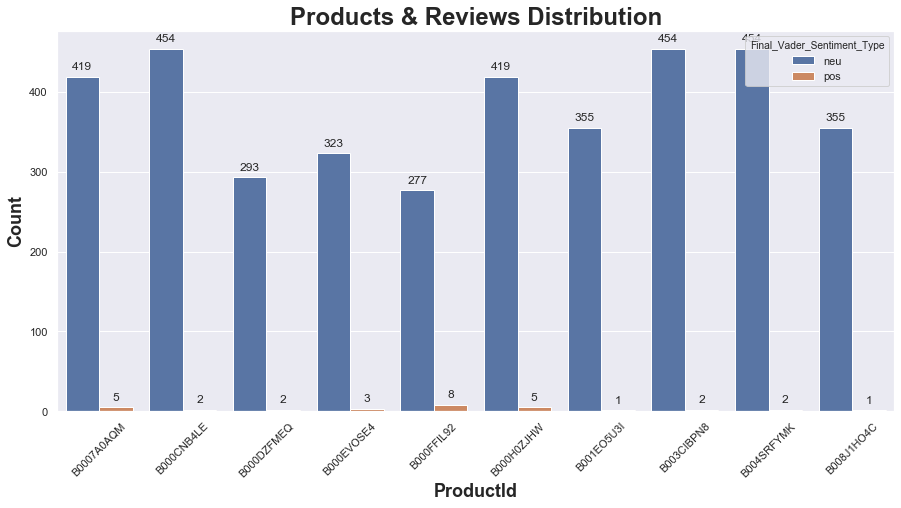

In [39]:
product_review_groupby_vader = df_final.groupby(['ProductId','Final_Vader_Sentiment_Type']).count()['Id'].reset_index()

plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Id", hue="Final_Vader_Sentiment_Type", data=product_review_groupby_vader)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks(rotation=45)
plt.title('Products & Reviews Distribution',fontsize=24, y=1, weight = 'bold')
for p in bar_plot.patches:
    bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Count',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();


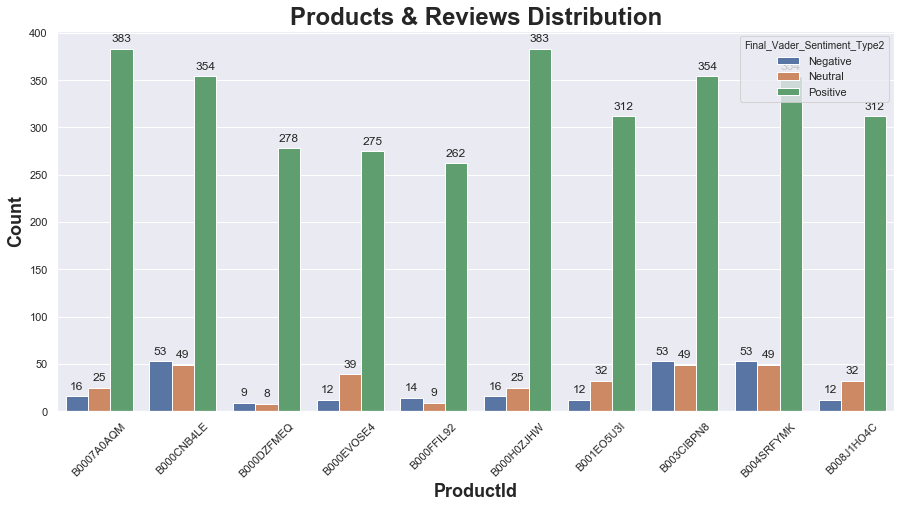

In [40]:
product_review_groupby_vader = df_final.groupby(['ProductId','Final_Vader_Sentiment_Type2']).count()['Id'].reset_index()

plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x="ProductId", y="Id", hue="Final_Vader_Sentiment_Type2", data=product_review_groupby_vader)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.xticks(rotation=45)
plt.title('Products & Reviews Distribution',fontsize=24, y=1, weight = 'bold')
for p in bar_plot.patches:
    bar_plot.annotate(str(format(p.get_height(), '.0f')), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Count',fontsize=18, weight = 'bold')
plt.xlabel('ProductId',fontsize=18, weight = 'bold')
plt.show();

# Sentiment Analysis using TF-IDF

In [41]:
reviews = []
for i in df_final.index:
    reviews.append(df_final.loc[i,'Text'].lower().split())

In [42]:
# Document Frequency calculation
DF = {}
for i in range(len(reviews)):
    tokens = reviews[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

In [43]:
## frequency of the word 
for i in DF:
    DF[i]= len(DF[i])
# DF

In [44]:
# calculating TF-IDF
import collections
tf_idf = {}
N = len(reviews) # number of reviews
tf_idf =[] 
for i in range(N):
    tokens = reviews[i]
    counter = collections.Counter(tokens) # contains counts of all words in 1 review
    words_count = len(tokens) # total words in 1 review
    tf_idf_temp ={}
    for token in np.unique(tokens):
        tf = counter[token]/words_count   # count of single word/total words
        df = DF[token]  # document frequency
        
        idf = np.log(N/df)  # IDF
    
        tf_idf_temp[token] =tf*idf #tf-idf
    tf_idf.append(tf_idf_temp)

In [45]:
# Reading the lexicon file and cleaning it to remove '#'
lex = pd.read_excel("General Inquiry lexicon.xls")
lex = lex[1:]
lex['Entry'] = lex['Entry'].astype(str)
# special_char_list=['</span','<br/>','<br>','href','</a>''\\','`','\"',"'",'*','_','{','}','[',']','(',')',';','@','^','&','>','#1','+',':','-','_','=','|','>','<','~','.','!','$','/',',','?','%','0','1','2','3','4','5','6','7','8','9']
lex['Entry']=lex['Entry'].apply(clean_text)

In [46]:
pos_word = lex[lex['Positiv'].notnull()]
positive_word =list(pos_word['Entry'])

neg_word = lex[lex['Negativ'].notnull()]
negative_word =list(neg_word['Entry'])

In [47]:
# Considering negations
import nltk
negation=['no', 'not', 'none', 'neither', 'never', 'nobody','nothing','nowhere','hardly','scarcely','barely',"doesnt","isnt","dont","wasnt","shouldnt","wouldnt","couldnt","wont","cant"]
    
def negate_pos(text):
    negative_pos = []
    wordlist=nltk.word_tokenize(text)
    for index,word in enumerate(wordlist):
        if word.upper() in positive_word:
            word1=wordlist[index-1] if index>=1 else 'NA'
            word2=wordlist[index-2] if index>=2 else "NA"
            word3=wordlist[index-3] if index>=3 else "NA"
            if (word1 in negation) or (word2 in negation) or (word3 in negation):
                negative_pos.append(word)
                
    return negative_pos

def negate_neg(text):
    negative_neg = []
    wordlist=nltk.word_tokenize(text)
    for index,word in enumerate(wordlist):
        if word.upper() in negative_word:
            word1=wordlist[index-1] if index>=1 else 'NA'
            word2=wordlist[index-2] if index>=2 else "NA"
            word3=wordlist[index-3] if index>=3 else "NA"
            if (word1 in negation) or (word2 in negation) or (word3 in negation):
                negative_neg.append(word)
    return negative_neg

In [48]:
# Positive Sentiment
pos_sentiment_score=[]
pos_word_number = []
for i in range(len(tf_idf)):
    tf_idf_dict = tf_idf[i]
    pword_counter = 0
    line_sent_score=0
    for word,score in tf_idf_dict.items():
        if word.upper() in positive_word:
            pword_counter =pword_counter+1
            line_sent_score=line_sent_score+score
    # Consider negations
    text = df_final.loc[i,'Text'].lower()
    negated_pos = negate_pos(text)
    negated_neg = negate_neg(text)
    pword_counter = pword_counter - len(negated_pos)
    pword_counter = pword_counter + len(negated_neg)
    
    for pos_word in negated_pos:
        line_sent_score = line_sent_score - tf_idf_dict[pos_word]
    for neg_word in negated_neg:
        line_sent_score = line_sent_score + tf_idf_dict[neg_word]
    
    pos_sentiment_score.append(line_sent_score)
    pos_word_number.append(pword_counter)

KeyError: 295

In [ ]:
# negative sentiment
neg_sentiment_score=[]
neg_word_number=[]
for i in range(len(tf_idf)):
    tf_idf_dict = tf_idf[i]
    nword_counter=0
    line_sent_score=0
    
    for word,score in tf_idf_dict.items():
        if word.upper() in negative_word:
            nword_counter =nword_counter+1
            line_sent_score=line_sent_score+score
    
    # Consider negations
    text = df_final.loc[i,'Text'].lower()       
    negated_pos = negate_pos(text)    
    negated_neg = negate_neg(text)
    nword_counter = nword_counter + len(negated_pos)
    nword_counter = nword_counter - len(negated_neg)
    
    for pos_word in negated_pos:
        line_sent_score = line_sent_score + tf_idf_dict[pos_word]
    for neg_word in negated_neg:
        line_sent_score = line_sent_score - tf_idf_dict[neg_word]
    
    neg_sentiment_score.append(line_sent_score)
    neg_word_number.append(nword_counter)


In [ ]:
df_final["neg_sentiment_score"]=neg_sentiment_score

df_final["pos_sentiment_score"]=pos_sentiment_score

df_final["neg_word_count"]=neg_word_number

df_final["pos_word_count"]=pos_word_number

In [ ]:
#calculate normalized score
from past.builtins import xrange
nums = [0,len(df_final["Text"])]
normalized_pos_sentiment_score = []
for i in xrange(nums[0],nums[1]):
    word_count=len(df_final.loc[i,"Text"].split(" "))
    normalized_score=(df_final.loc[i,"pos_sentiment_score"])/word_count
    normalized_pos_sentiment_score.append(normalized_score)

In [ ]:
# calculate normalized score
from past.builtins import xrange
nums = [0,len(df_final["Text"])]
normalized_neg_sentiment_score = []
for i in xrange(nums[0],nums[1]):
    word_count=len(df_final.loc[i,"Text"].split(" "))
    normalized_score=(df_final.loc[i,"neg_sentiment_score"])/word_count # dividing sentiment score by word count of each review
    normalized_neg_sentiment_score.append(normalized_score)

In [ ]:
df_final["normalized_neg__sentiment_score"]=normalized_neg_sentiment_score

df_final["normalized_pos__sentiment_score"]=normalized_pos_sentiment_score

In [ ]:
# calculate positive sentiment ratio
positive_ratio = []
for index, row in df_final.iterrows():
    if (row['normalized_pos__sentiment_score'] == 0) and (row['normalized_neg__sentiment_score'] == 0):
        positive_ratio.append(-1)
    else:
        ratio = row['normalized_pos__sentiment_score']/(row['normalized_pos__sentiment_score']+row['normalized_neg__sentiment_score'])
        positive_ratio.append(ratio)
df_final['positive_ratio'] = positive_ratio

In [ ]:
# calculated sentiment
df_final.loc[df_final.positive_ratio>0.55,'calculated_sentiment'] = 'Positive'
df_final.loc[(df_final.positive_ratio > 0.45) & (df_final.positive_ratio <= 0.55) ,'calculated_sentiment'] = 'Neutral'
df_final.loc[(df_final.positive_ratio >= 0.000000) & (df_final.positive_ratio <= 0.45) ,'calculated_sentiment'] = 'Negative'
df_final.loc[df_final.positive_ratio == -1 ,'calculated_sentiment'] = 'Undefined'
df_final.head()

# Sentiment analysis with Textblob

In [ ]:
df_textBlob = copy.deepcopy(df_final)

In [ ]:
df_textBlob.head()

In [ ]:
for i in df_textBlob.index:
    text = TextBlob(df_textBlob.loc[i,'Text'])
    df_textBlob.loc[i,'polarity'] = text.sentiment.polarity
    df_textBlob.loc[i,'subjectivity'] = text.sentiment.subjectivity
    
    if text.sentiment.polarity >0 and text.sentiment.subjectivity > 0.5:
        df_textBlob.loc[i,'TextBlob_Sentiment'] = 'Positive'
    elif text.sentiment.polarity <= 0 and text.sentiment.subjectivity > 0.5:
        df_textBlob.loc[i,'TextBlob_Sentiment'] = 'Negative'
    else:
        df_textBlob.loc[i,'TextBlob_Sentiment'] = 'Neutral'


In [ ]:
df_textBlob.head()

# Check the accuracy

In [ ]:
def accuracy(df):
    acc1 = len(np.where(df['TextBlob_Sentiment']==df['Score_Sentiment'])[0])/len(df)*100
    acc2 = len(np.where(df['calculated_sentiment']==df['Score_Sentiment'])[0])/len(df)*100
    acc3 = len(np.where(df['Final_Vader_Sentiment_Type2']==df['Score_Sentiment'])[0])/len(df)*100
    data = [['TextBlob',acc1],['TF-IDF',acc2],['Vader',acc3]]
    df = pd.DataFrame(data,columns=['Methods','Accuracy'])
    return df

In [ ]:
accuracy(df_textBlob)